# Analýza hrubého domácího produktu evropských zemí v roce 2022.

Naimportujeme knihovny pro zpracování a vizualizaci dat, vytváření tabulek a provedení dalších statistických operací.

In [1]:
library(eurostat)
library(vtable)
library(ggplot2)
library(olsrr)
library(lmtest)
library(tibble)
library(moments)
library(cowplot)
library(car)
library(MASS)


options(width=200, repr.plot.width=13, repr.plot.height=10) 
options(scipen = 5)

Loading required package: kableExtra


Attaching package: ‘olsrr’


The following object is masked from ‘package:datasets’:

    rivers


Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: carData


Attaching package: ‘MASS’


The following object is masked from ‘package:olsrr’:

    cement




## Úloha 1

### Prezentace dat

> Krátce prezentujte rozdělení HDP a jeho charakteristiky číselně i graficky.

Na základě identifikátoru datasetu načteme potřebná data z Eurostatu.

In [3]:
id <- "nama_10_gdp" 
data <- get_eurostat(id=id)

Odfiltrujeme data podle pokynů úlohy. Zajímá nás výpočet tržních cen, kde hodnota `na_item` je `B1GQ`, jednotka `unit` je `CP_MEUR` (vyjádření v milionech eur) a rok `time` je `2022-01-01`.

In [4]:
data_de <- data[data$na_item=="B1GQ",]
data_de <- data_de[data_de$unit=="CP_MEUR",]
data_de <- data_de[data_de$time >= "2022-01-01",]
head(data_de)
tail(data_de)

unit    na_item geo time       values  
1 CP_MEUR B1GQ    AL  2022-01-01  17939.7
2 CP_MEUR B1GQ    AT  2022-01-01 446933.3
3 CP_MEUR B1GQ    BA  2022-01-01  23317.3
4 CP_MEUR B1GQ    BE  2022-01-01 549456.2
5 CP_MEUR B1GQ    BG  2022-01-01  84560.6
6 CP_MEUR B1GQ    CH  2022-01-01 767616.2

unit    na_item geo time       values  
1 CP_MEUR B1GQ    RS  2022-01-01  60367.9
2 CP_MEUR B1GQ    SE  2022-01-01 560958.6
3 CP_MEUR B1GQ    SI  2022-01-01  58988.5
4 CP_MEUR B1GQ    SK  2022-01-01 109651.9
5 CP_MEUR B1GQ    TR  2022-01-01 862010.8
6 CP_MEUR B1GQ    XK  2022-01-01   8954.9

Sloupce `time`, `unit` a `na_item` už nepotřebujeme, proto je odstraníme.

In [5]:
data_de$time <- NULL
data_de$unit <- NULL
data_de$na_item <- NULL
head(data_de)
tail(data_de)

geo values  
1 AL   17939.7
2 AT  446933.3
3 BA   23317.3
4 BE  549456.2
5 BG   84560.6
6 CH  767616.2

geo values  
1 RS   60367.9
2 SE  560958.6
3 SI   58988.5
4 SK  109651.9
5 TR  862010.8
6 XK    8954.9

Pojďme se podívat na hodnoty HDP.

In [6]:
data_de

geo       values    
1  AL           17939.7
2  AT          446933.3
3  BA           23317.3
4  BE          549456.2
5  BG           84560.6
6  CH          767616.2
7  CY           27006.4
8  CZ          276605.9
9  DE         3869900.0
10 DK          376087.2
11 EA        13332098.1
12 EA12      12977493.6
13 EA19      13332098.1
14 EA20      13399037.1
15 EE           36181.4
16 EL          208030.2
17 ES         1327108.0
18 EU27_2020 15810286.6
19 FI          266679.0
20 FR         2639092.0
21 HR           66939.0
22 HU          170246.8
23 IE          502583.5
24 IS           26479.3
25 IT         1909153.6
26 LT           66791.1
27 LU           78130.1
28 LV           39062.5
29 ME            5796.8
30 MK           12897.8
31 MT           16922.6
32 NL          941186.0
33 NO          551408.9
34 PL          656905.5
35 PT          239241.7
36 RO          285884.8
37 RS           60367.9
38 SE          560958.6
39 SI           58988.5
40 SK          109651.9
41 TR          862010.8
42 XK            8954.9

Vzhledem k tomu, že identifikátory 'EA', 'EA12', 'EA19', 'EA20' a 'EU27_2020' popisují celkový HDP skupiny zemí a my se zajímáme o jednotlivé ukazatele každé země, odstraníme záznamy s těmito identifikátory.

In [7]:
data_countries <- data_de[!(data_de$geo %in% c('EA', 'EA12', 'EA19', 'EA20', 'EU27_2020')),]
head(data_countries)
dim(data_countries)

geo values  
1 AL   17939.7
2 AT  446933.3
3 BA   23317.3
4 BE  549456.2
5 BG   84560.6
6 CH  767616.2

[1] 37  2

V našem datasetu je zastoupeno 37 různých zemí.

Pomocí knihovny `vtable` se podíváme na číselné charakteristiky HDP (popisné statistiky).

In [8]:
summ <- c('mean(x)', 'sd(x)', 'min(x)', 'pctile(x)[25]', 'median(x)', 'pctile(x)[75]', 
          'max(x)', 'IQR(x)', 'skewness(x)', 'kurtosis(x)')
df <- tibble(data_countries$values)
View(sumtable(df,  out="return", summ=summ, ))

Variable              Mean   Sd     Min  Pctile[25] Median Pctile[75] Max     IQR    Skewness Kurtosis
1 data_countries$values 490462 799592 5797 39062      208030 551409     3869900 512346 2.8      11

Šikmost (skewness) regresandu je kladná, což znamená, že data že data jsou více sešikmená vpravo. Špičatost (kurtosis) je také kladná, což naznačuje vyšší koncentraci dat blíže k vyběrovému průměru. Vyběrový průměr je mnohem větší než medián, což naznačuje přítomnost odlehlých pozorování.

Také znázorníme je graficky.

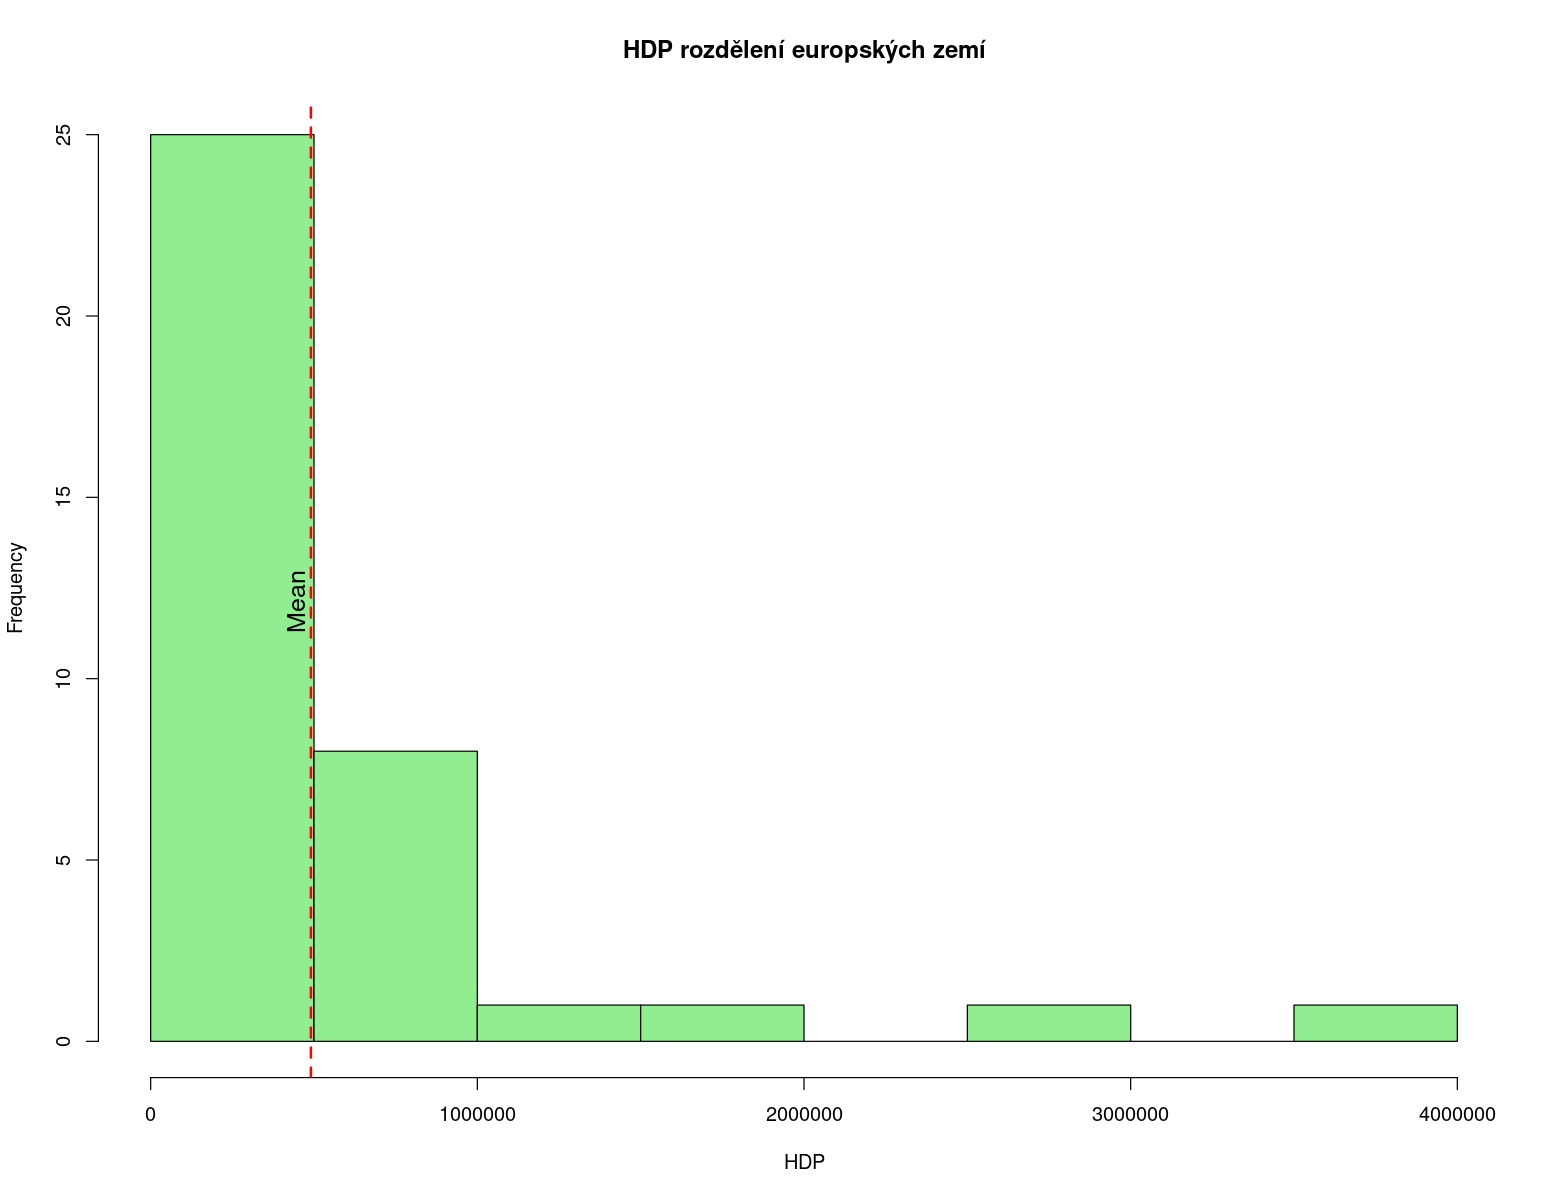

In [9]:
hist(data_countries$values, prob=F, col="Lightgreen", main="HDP rozdělení europských zemí", xlab = "HDP")
abline(v = mean(data_countries$values), col = "red", lty = 2, lwd=2)
text(mean(data_countries$values), 13, "Mean", pos = 2, srt = 90, cex=1.25)

Histogram také potvrzuje sešikmenost vpravo a koncentraci dat kolem vyběrového průměru.

Pro další průzkum dat použijeme box-plot a viollin-plot.

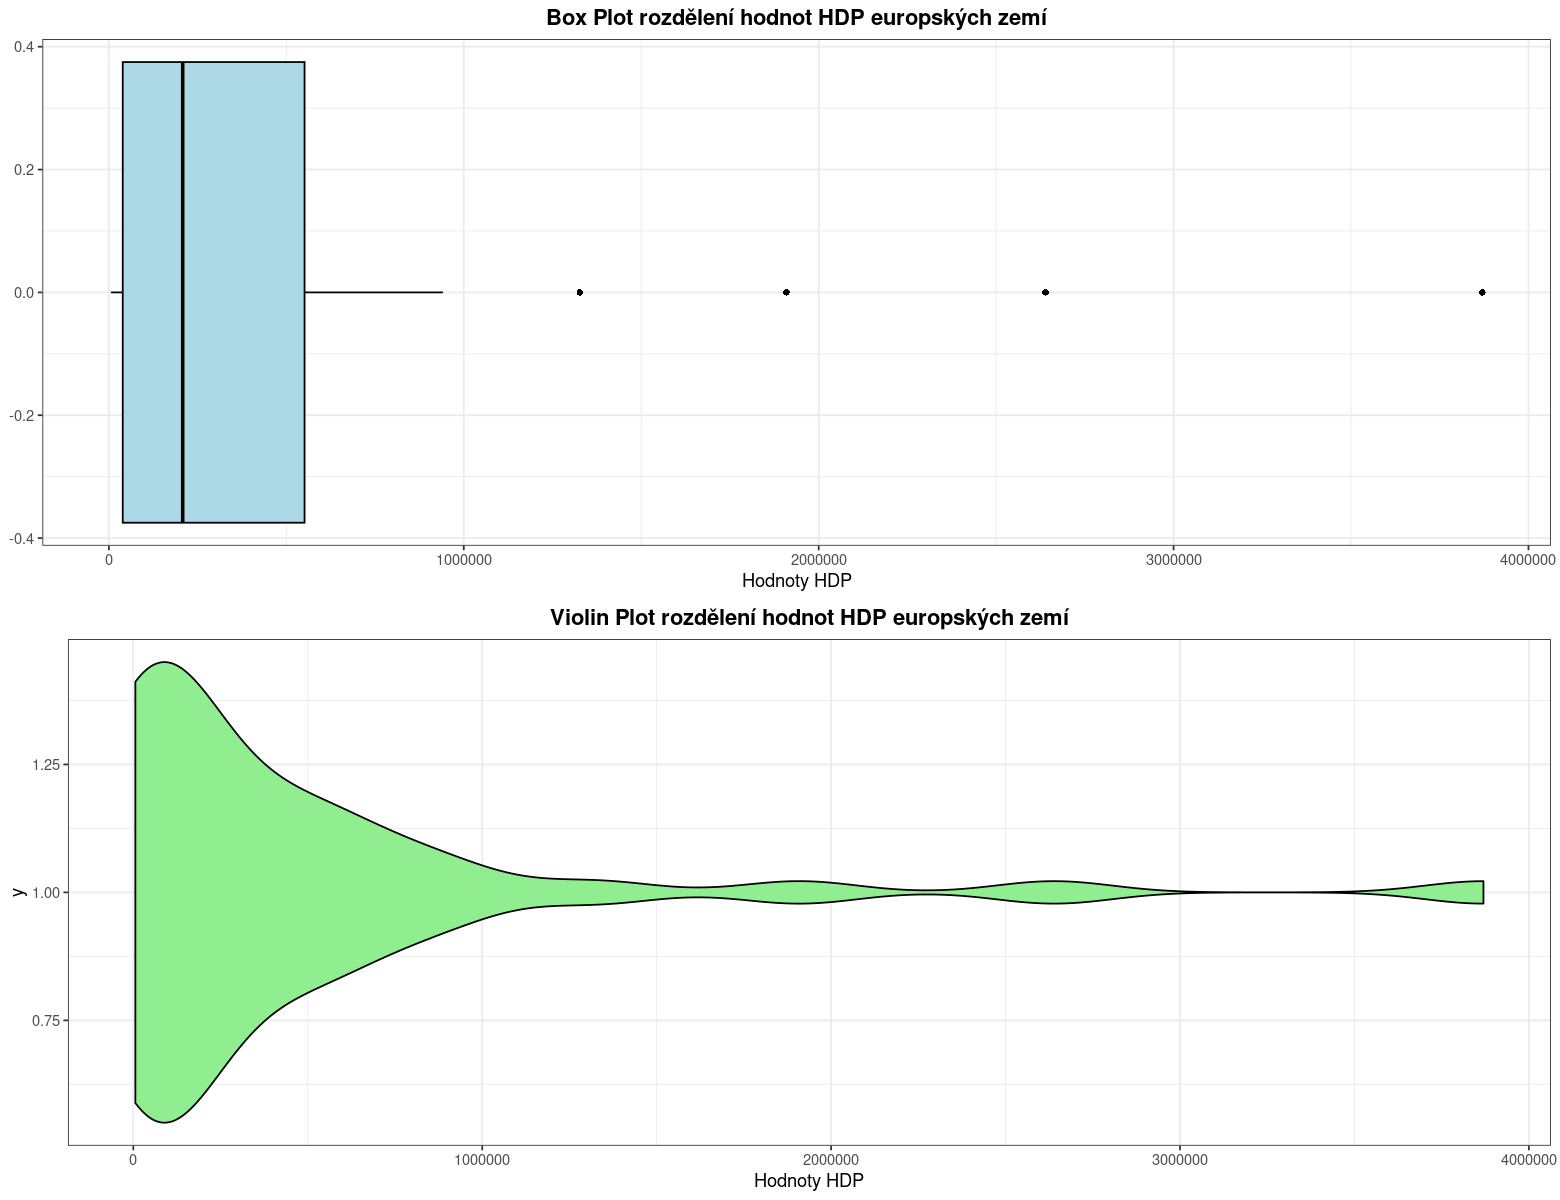

In [10]:
boxplot <- ggplot(data_countries, aes(x = values)) +
  geom_boxplot(fill = "lightblue", color = "black", outlier.shape = 16, outlier.color = "black") +
  xlab("Hodnoty HDP") +
  ggtitle("Box Plot rozdělení hodnot HDP europských zemí") +
  theme_bw() +
  theme(plot.title = element_text(face = "bold", hjust = 0.5))

violinplot <- ggplot(data_countries, aes(x = values, y = 1)) +
  geom_violin(fill = "lightgreen", color = "black") +
  xlab("Hodnoty HDP") +
  ggtitle("Violin Plot rozdělení hodnot HDP europských zemí") +
  theme_bw() +
  theme(plot.title = element_text(face = "bold", hjust = 0.5))

plot_grid(boxplot, violinplot, nrow = 2)

Na box plotu je patrné, že se vyskytují 4 odlehlá pozorování (což ovšem vyžaduje další ověření vhodnými testy). Z violin plotu je jasně viditelná distribuce hodnot HDP.

### Diskuze o regresorech

> Diskutujte, které údaje o zemích by mohly mít na HDP vliv.


**HDP (Hrubý domácí produkt)** je ekonomický ukazatel, který měří celkovou hodnotu všech finálních statků a služeb vyprodukovaných v rámci ekonomiky dané země za určité období (v našem případě za rok 2022) . Obecně lze říci, že HDP země může být ovlivněn mnoha různými faktory, včetně ekonomických (protože HDP je především ekonomický ukazatel), demografických, geografických, politických, ekologických a mnoha dalších.

Nejprve zkusíme **demografický faktor**, který je vyjádřen počtem obyvatelů. Předpokládáme kladnou korelaci s vysvětlovanou hodnotou - čím více je obyvatelů, tím větší je HDP země.

Jako druhý regresor chceme vyzkoušet **eurozónu**. Euro se považuje za tvrdou měnu a předpokládáme, že země, které obchodují v eurech, mají vyšší HDP.

Třetím faktorem je **ekonomický faktor** - [harmonizovaný index spotřebitelských cen](https://www.ecb.europa.eu/ecb/educational/explainers/tell-me-more/html/what_is_inflation.cs.html#:~:text=harmonizovan%C3%BDm%20indexem%20spot%C5%99ebitelsk%C3%BDch%20cen%2C%20%C4%8Dasto,se%20ceny%20v%20ekonomice%20m%C4%9Bn%C3%AD), který pomáhá porovnávat ceny a inflaci mezi státy. Dopředu ale nevíme, zda má kladnou nebo zápornou korelaci s HDP.

Jako poslední regresor zvolíme **geografický faktor**, tedy rozdělení zemí do čtyř regionů: severní, jižní, západní a východní. Máme předpoklad, že západní Evropa by měla mít vyšší HDP, protože tam jsou země jako například Německo a Francie, které mají největší HDP.

## Úloha 2

### Přídaní nových regresorů

> Pro zkoumané země si vhodně zvolte čtyři údaje dostupné z databází Eurostatu či jiných externích zdrojů. Může se jednat např. o demografické, geografické nebo ekonomické ukazatele. Alespoň jedna proměnná nechť je numerická a alespoň jedna kategoriální (např. zda má země přístup k moři, zda se v zemi platí Eurem, jestli se jedná o monarchii nebo republiku,…).

#### Demografie

Začneme s demografickým příznakem - počtem obyvatel každého státu. Data o počtu obyvatel v jednotlivých evropských státech získáme z [datasetu](https://ec.europa.eu/eurostat/databrowser/view/demo_r_pjanaggr3/default/table?lang=en), který jsme používali v prvním semestrálním projektu.

In [11]:
dat_demog <- get_eurostat(id = 'demo_r_pjanaggr3')

Podívejme se, jak vypadá dataset.

In [12]:
head(dat_demog)

unit sex age   geo   time       values 
1 NR   F   TOTAL AT    2022-01-01 4553444
2 NR   F   TOTAL AT1   2022-01-01 2000081
3 NR   F   TOTAL AT11  2022-01-01  151557
4 NR   F   TOTAL AT111 2022-01-01   19074
5 NR   F   TOTAL AT112 2022-01-01   83093
6 NR   F   TOTAL AT113 2022-01-01   49390

Odfiltrujeme data podle roku 2022. Vzhledem k tomu, že nezajímáme rozdělení podle pohlaví a věku, vybereme pouze hodnoty pro kategorii `TOTAL`. Dále potřebujeme rozdělení podle NUTS-1, takže filtrujeme položku `geo` podle délky 2.

In [13]:
data_demog <- dat_demog[dat_demog$time == '2022-01-01',]
data_demog_total <- data_demog[data_demog$age =='TOTAL',]
data_demog_total <- data_demog_total[data_demog_total$sex =='T',]
data_demog_total <- data_demog_total[nchar(data_demog_total$geo) == 2,]
head(data_demog_total)
dim(data_demog_total)

unit sex age   geo time       values  
1 NR   T   TOTAL AT  2022-01-01  8978929
2 NR   T   TOTAL BE  2022-01-01 11617623
3 NR   T   TOTAL BG  2022-01-01  6838937
4 NR   T   TOTAL CH  2022-01-01  8738791
5 NR   T   TOTAL CY  2022-01-01   904705
6 NR   T   TOTAL CZ  2022-01-01 10516707

[1] 34  6

Bohužel, tento dataset neobsahuje všechny státy, které potřebujeme pro zkoumání. Proto budeme muset data o těchto státech doplnit ručně.</br> 
V rámci úprav datového souboru odstraníme sloupce `unit`, `time`, `sex` a `age`, protože již nejsou potřebné. Také přejmenujeme sloupec `values` na `population`.

In [14]:
data_demog_total$unit <-NULL
data_demog_total$time <-NULL
data_demog_total$sex <-NULL
data_demog_total$age <-NULL
names(data_demog_total)[names(data_demog_total) == "values"] <- "population"
head(data_demog_total)
dim(data_demog_total)

geo population
1 AT   8978929  
2 BE  11617623  
3 BG   6838937  
4 CH   8738791  
5 CY    904705  
6 CZ  10516707

[1] 34  2

Spojujeme vzniklý dataset o počtu obyvatelů s naším hlavním datasetem (HDP států) na základě společného sloupce `geo`.

In [15]:
merged_dataset <- merge(data_countries, data_demog_total, by = "geo", all.x = T)
head(merged_dataset)

geo values   population
1 AL   17939.7       NA  
2 AT  446933.3  8978929  
3 BA   23317.3       NA  
4 BE  549456.2 11617623  
5 BG   84560.6  6838937  
6 CH  767616.2  8738791

Jak jsme zmíněli předtím, pro některé státy v tomto datasetu nejsou k dispozici informace o počtu obyvatelů, proto je budeme muset doplnit z [jiného](https://countrymeters.info/en/Albania) zdroje.

In [16]:
merged_dataset[1, 3]   <- 2877275   #AL 
merged_dataset[3, 3]   <- 3282300   #BA 
merged_dataset[36, 3]  <- 86735919  #TR 
merged_dataset[37, 3]  <- 1768942   #XK 

Ověříme, zda data po doplnění neobsahují žádné chybějící hodnoty (`NA`).

In [17]:
cat("Počet NA hodnot:", sum(is.na(merged_dataset)))

Počet NA hodnot: 0

#### Euro area


Vytvoříme v datasetu sloupec s názvem `euro`, který bude obsahovat logické hodnoty indikující, zda daná země patří do eurozóny nebo ne. Použijeme informace z odkazu [odsud](https://european-union.europa.eu/institutions-law-budget/euro/countries-using-euro_en). Vzhledem k tomu, že Chorvatsko se připojilo k eurozóně až v roce 2023, nezahrneme ho.

In [18]:
geo_euro <- c("BE", "IE", "CY", "LU", "AT", 
              "SK", "DE", "EL", "LV", "MT", 
              "PT", "FI", "EE", "ES", "IT", 
              "LT", "NL", "SI", "FR")

merged_dataset$euro <- merged_dataset$geo %in% geo_euro
head(merged_dataset)

geo values   population euro 
1 AL   17939.7  2877275   FALSE
2 AT  446933.3  8978929    TRUE
3 BA   23317.3  3282300   FALSE
4 BE  549456.2 11617623    TRUE
5 BG   84560.6  6838937   FALSE
6 CH  767616.2  8738791   FALSE

#### HICP

Načítáme data o harmonizovaném indexu spotřebitelských cen (HICP) v jednotlivých evropských státech, která jsme nalezli na [Eurostatu](https://ec.europa.eu/eurostat/databrowser/view/prc_hicp_midx/default/table?lang=en).

In [19]:
dat_hicp <- get_eurostat(id = 'prc_hicp_midx')
head(dat_hicp)

unit coicop geo time       values
1 I15  CP00   AT  2023-05-01 130.01
2 I15  CP00   BE  2023-05-01 124.92
3 I15  CP00   CY  2023-05-01 114.06
4 I15  CP00   EA  2023-05-01 123.16
5 I15  CP00   EE  2023-05-01 150.10
6 I15  CP00   EL  2023-05-01 116.19

Filtrujeme data o harmonizovaném indexu spotřebitelských cen (HICP). Nejprve filtrujeme podle kódu `coicop` rovného `CP00`, což představuje HICP pro všechny druhy zboží. Poté provádíme filtraci podle roku `2022-01-01`. Nakonec filtrujeme podle jednotky měření (`unit`) `I15`, která představuje nejnovější dostupnou jednotku.

In [20]:
data_hicp <- dat_hicp[dat_hicp$coicop == 'CP00',]
data_hicp <- data_hicp[data_hicp$time == '2022-01-01',]
data_hicp <- data_hicp[data_hicp$unit == 'I15',]

V rámci úprav datového souboru odstraníme sloupce `unit`, `time`,  a `coicop`, protože již nejsou potřebné. Také přejmenujeme sloupec `values` na `hicp`.

In [21]:
data_hicp['unit'] <- NULL
data_hicp['coicop'] <- NULL
data_hicp['time'] <- NULL
names(data_hicp)[names(data_hicp) == "values"] <- "hicp"
head(data_hicp)

geo hicp  
1 AL  116.03
2 AT  113.93
3 BE  116.99
4 BG  114.80
5 CH  101.69
6 CY  103.33

Spojujeme vzniklý dataset s hodnotámi HICP s naším hlavním datasetem na základě společného sloupce `geo`. 
Také ověříme, zda náš dataset obsahuje hodnoty `NA`.

In [22]:
merged_dataset3 <- merge(merged_dataset, data_hicp, by = "geo", all.x = T)
head(merged_dataset3)
cat("Počet NA hodnot:", sum(is.na(merged_dataset3)))

geo values   population euro  hicp  
1 AL   17939.7  2877275   FALSE 116.03
2 AT  446933.3  8978929    TRUE 113.93
3 BA   23317.3  3282300   FALSE     NA
4 BE  549456.2 11617623    TRUE 116.99
5 BG   84560.6  6838937   FALSE 114.80
6 CH  767616.2  8738791   FALSE 101.69

Počet NA hodnot: 1

Pro jeden stát na Eurostatu nemáme k dispozici údaje o HICP, proto jej musíme doplnit z jiného [zdroje](https://tradingeconomics.com/bosnia-and-herzegovina/consumer-price-index-cpi).

In [23]:
merged_dataset3[3, 5] <- 107.1   #BA
head(merged_dataset3)

geo values   population euro  hicp  
1 AL   17939.7  2877275   FALSE 116.03
2 AT  446933.3  8978929    TRUE 113.93
3 BA   23317.3  3282300   FALSE 107.10
4 BE  549456.2 11617623    TRUE 116.99
5 BG   84560.6  6838937   FALSE 114.80
6 CH  767616.2  8738791   FALSE 101.69

#### GEO regions

Rozšíříme dataset o geografický příznak, který bude zahrnovat třídění států do čtyř kategorií na základě [UN geoscheme](https://en.wikipedia.org/wiki/Regions_of_Europe#/media/File:Europe_subregion_map_UN_geoscheme.svg).

In [24]:
north_geo   <- c('NO', 'DK', 'SE', 'FI', 'IS', 'IE', 'EE', 'LT', 'LV')
east_geo    <- c('CZ', 'PL', 'HR', 'SK', 'RO', 'HU', 'BG', 'RS', 'XK', 'AL', 'MK', 'BA', 'ME', 'SI')
west_geo    <- c('FR', 'DE', 'AT', 'CH', 'LU', 'BE', 'NL')
south_geo   <- c('ES', 'IT', 'PT', 'EL', 'CY', 'MT', 'TR')

In [25]:
merged_dataset3$region[merged_dataset3$geo %in% north_geo] <- "NORTH"
merged_dataset3$region[merged_dataset3$geo %in% east_geo] <- "EAST"
merged_dataset3$region[merged_dataset3$geo %in% west_geo] <- "WEST"
merged_dataset3$region[merged_dataset3$geo %in% south_geo] <- "SOUTH"

In [26]:
head(merged_dataset3)
dim(merged_dataset3)

geo values   population euro  hicp   region
1 AL   17939.7  2877275   FALSE 116.03 EAST  
2 AT  446933.3  8978929    TRUE 113.93 WEST  
3 BA   23317.3  3282300   FALSE 107.10 EAST  
4 BE  549456.2 11617623    TRUE 116.99 WEST  
5 BG   84560.6  6838937   FALSE 114.80 EAST  
6 CH  767616.2  8738791   FALSE 101.69 WEST

[1] 37  6

Přejmenujme výsledný dataset pro snadnější práci a převeďme kategorické regresory na faktorovou reprezentaci.

In [27]:
data <- merged_dataset3
data$euro <- factor(data$euro)
data$region <- factor(data$region)
head(data)

geo values   population euro  hicp   region
1 AL   17939.7  2877275   FALSE 116.03 EAST  
2 AT  446933.3  8978929   TRUE  113.93 WEST  
3 BA   23317.3  3282300   FALSE 107.10 EAST  
4 BE  549456.2 11617623   TRUE  116.99 WEST  
5 BG   84560.6  6838937   FALSE 114.80 EAST  
6 CH  767616.2  8738791   FALSE 101.69 WEST

### Ověření vztahu k HDP

> Tyto údaje budou sloužit jako regresory, proto je zvolte tak, aby modelovanou veličinu alespoň v minimální míře determinovaly. Vztah k HDP ověřte.

Příznaky `euro` a `region` jsou kategorické. K ověření jejich vztahu k HDP použijeme boxploty. Boxploty nám umožňují vizuálně porovnat rozdělení hodnoty HDP pro různé hodnoty regresorů a identifikovat případné rozdíly mezi nimi. Tímto způsobem můžeme získat předběžné informace o vztahu mezi regresory a HDP a případně identifikovat potenciální vzorce nebo trendy. První boxplot porovnává distribuci hodnot HDP v závislosti na eurozóně (tzn, patří-li stát do eurozóny). Z grafu je patrné, že hodnoty HDP mají tendenci být vyšší v zemích eurozóny (rozdíl se však nejeví jako významný). Druhý boxplot porovnává distribuci hodnot regresandu v různých regionech. Graf ukazuje, že existují významné rozdíly ve hodnotách regresoru mezi různými regiony (ve západním regionu jsou hodnoty nejvyšší, což potvrzuje předpoklad, který jsme měli předtím).

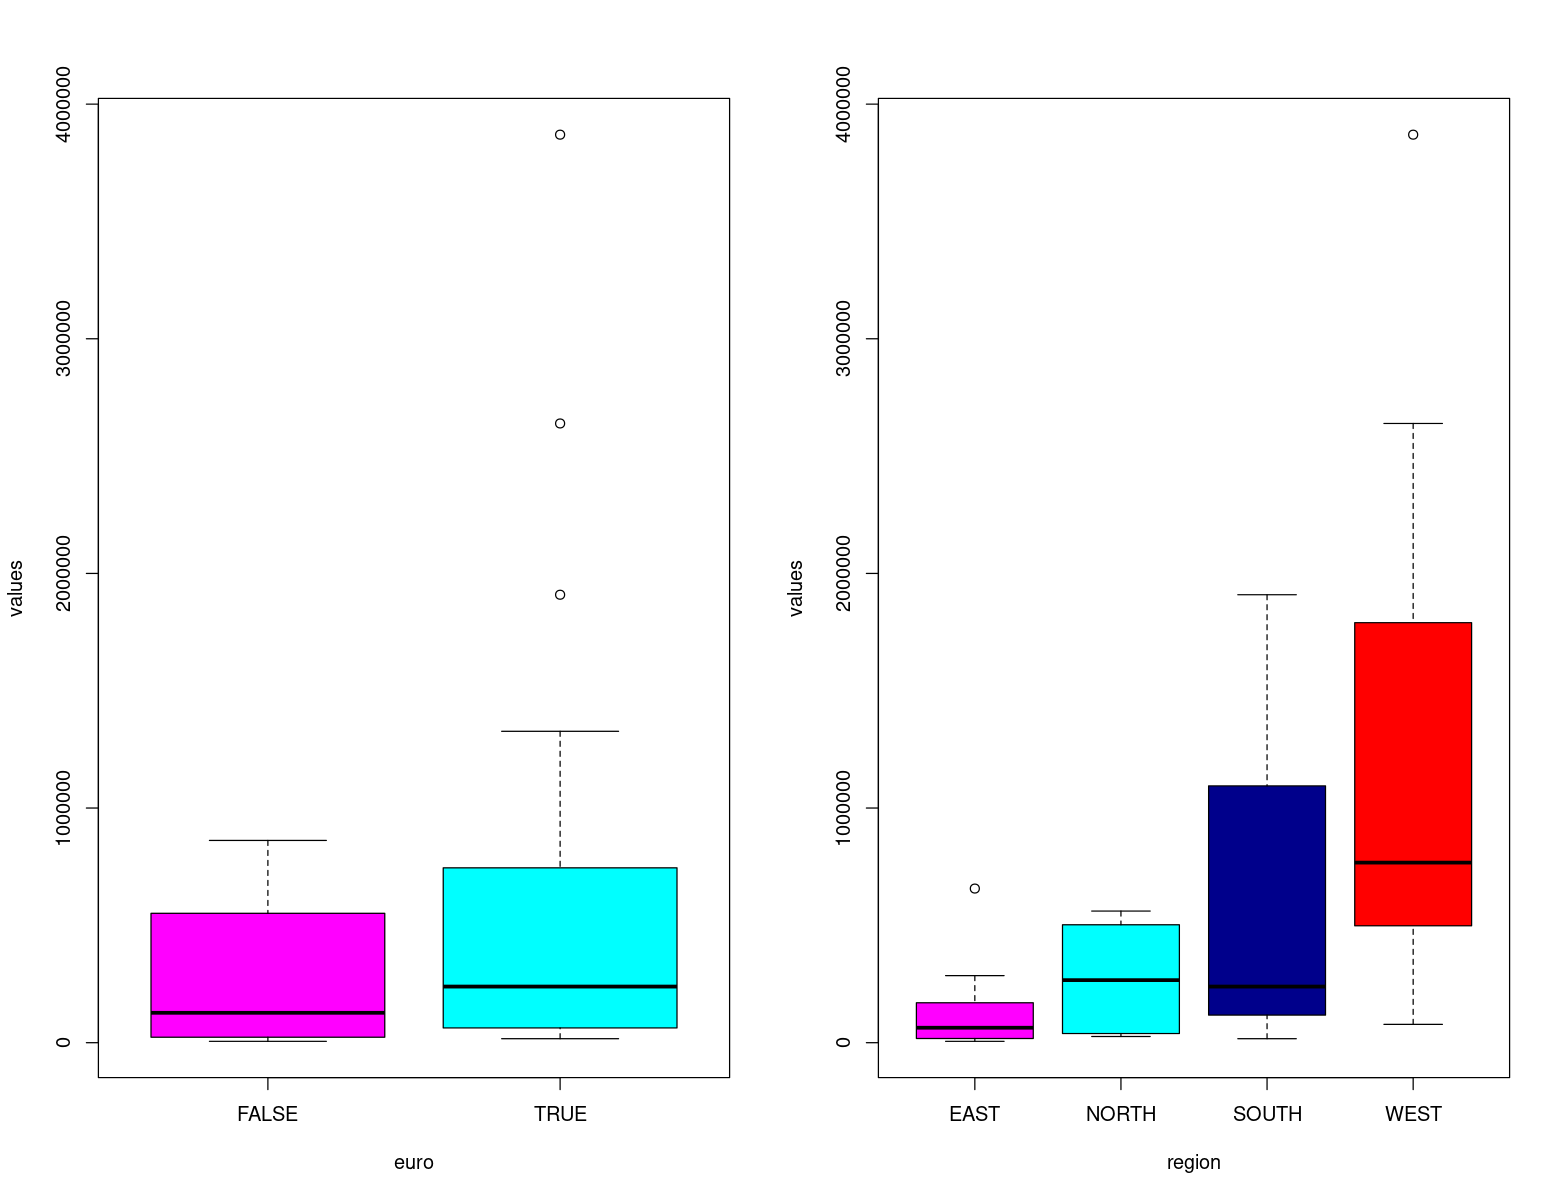

In [28]:
par(mfrow=c(1,2))
boxplot(values~euro, col=c("magenta","cyan"), data=data)
boxplot(values~region, col=c("magenta","cyan","darkblue", "red"), data=data)

Vztah mezi regresorem a regresandem také můžeme ověřit pomocí funkce `lm()`, která provádí lineární regresi a vrací výsledky, včetně testu na statistickou významnost vztahu. P-hodnota se v tomto kontextu používá ve spojitosti s nulovou hypotézou, která předpokládá, že neexistuje žádný vztah mezi regresorem a regresandem (koeficient regresoru je nulový).

In [29]:
fit.euro = lm(values~euro, data=data)
summary(fit.euro)


Call:
lm(formula = values ~ euro, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-684767 -462448 -207131  239497 3168211 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)  
(Intercept)   267499     183761   1.456   0.1544  
euroTRUE      434191     256436   1.693   0.0993 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 779600 on 35 degrees of freedom
Multiple R-squared:  0.07571,	Adjusted R-squared:  0.0493 
F-statistic: 2.867 on 1 and 35 DF,  p-value: 0.09931


Jak vidíme, p-hodnota je větší než standardní hladina významnosti, znamená to, že nezamítáme nulovou hypotézu. V tomto konkrétním případě to znamená, že koeficient regresoru `euro` nemá významný vliv na hodnotu HDP. Proto jej nepovažujeme za významný regresor ve vztahu k HDP a nemá smysl jej dále používat v modelu.

In [30]:
fit.region = lm(values~region, data=data)
summary(fit.region)


Call:
lm(formula = values ~ region, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-1249343  -243102   -72373   154524  2542427 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   131361     184209   0.713 0.480790    
regionNORTH   138220     294478   0.469 0.641890    
regionSOUTH   524278     319059   1.643 0.109837    
regionWEST   1196112     319059   3.749 0.000682 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 689200 on 33 degrees of freedom
Multiple R-squared:  0.3189,	Adjusted R-squared:  0.257 
F-statistic:  5.15 on 3 and 33 DF,  p-value: 0.004958


V případě regresoru `region` vidíme, že pro hodnotu regoinu `WEST` máme dostatečné důkazy pro zamítnutí nulové hypotézy. Tím pádem zjišťujeme, že region `WEST` má významný vliv na hodnotu HDP. Proto ponecháváme tento regresor v našem budoucím modelu.

Nyní se podíváme na závislosti mezi regresandem HDP a numerickými regresory. Znázorníme tyto vztahy pomocí scatter plotů.

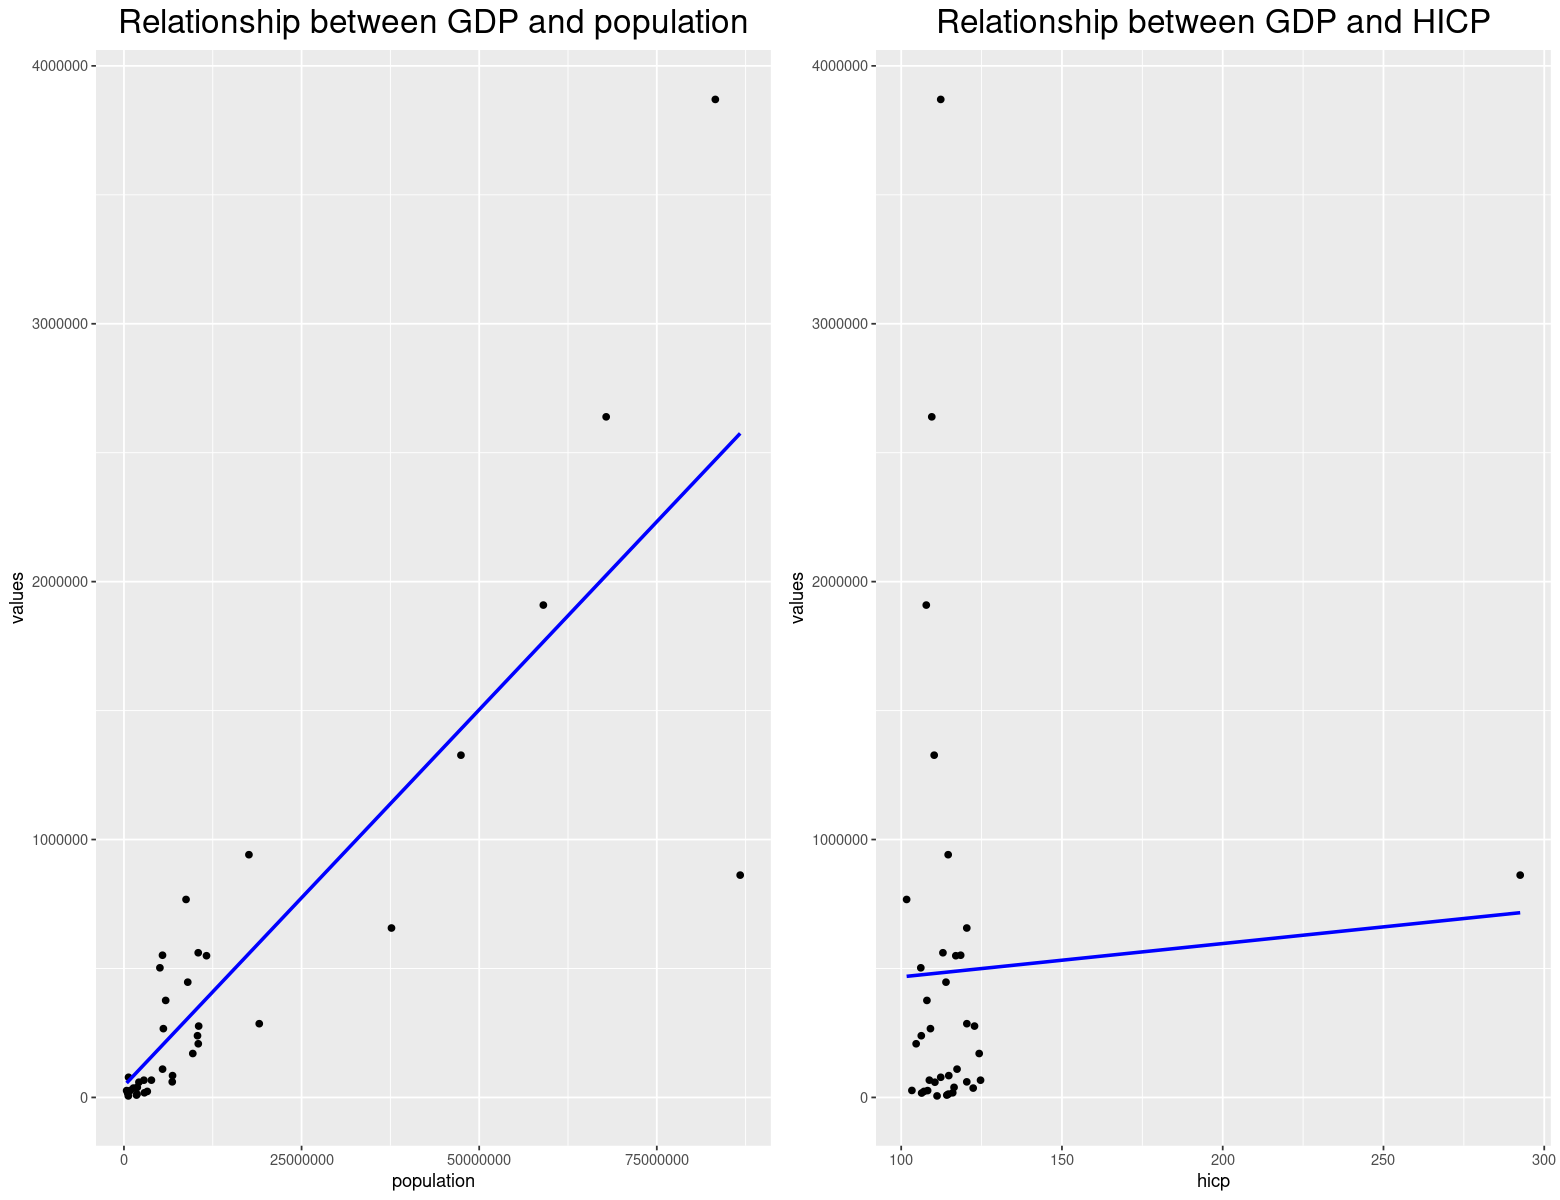

In [31]:
p1 <- ggplot(data, aes(x=population, y=values)) +
        geom_point() +
        stat_smooth(method="lm", formula=y~x, col="blue", se=F) +
        labs(title = "Relationship between GDP and population")+
        theme(plot.title = element_text(size = 20, hjust = 0.5))

p2 <- ggplot(data, aes(x=hicp, y=values)) +
        geom_point() +
        stat_smooth(method="lm", formula=y~x, col="blue", se=F) +
        labs(title = "Relationship between GDP and HICP")+
        theme(plot.title = element_text(size = 20, hjust = 0.5))

plot_grid(p1, p2, nrow=1)

Z těchto grafů je možné předpokládat, že počet obyvatel lépe vysvětluje HDP než HICP. V obou grafech je patrná určitá variabilita a několik odlehlých pozorování, ale ve grafu HICP/HDP vyskytuje významné odlehlé pozorování, které ovlivňuje směr lineární křivky("táhnou" nahoru). Pro přesnější závěry je však nezbytné provést další statistické testy.

In [32]:
fit.population = lm(values~population, data=data)
summary(fit.population)


Call:
lm(formula = values ~ population, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-1712895  -107608   -57109   142403  1397051 

Coefficients:
                Estimate   Std. Error t value Pr(>|t|)    
(Intercept) 44888.660433 85393.344236   0.526    0.602    
population      0.029169     0.003104   9.398 4.19e-11 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 432000 on 35 degrees of freedom
Multiple R-squared:  0.7162,	Adjusted R-squared:  0.7081 
F-statistic: 88.32 on 1 and 35 DF,  p-value: 4.194e-11


Koeficient regresoru `population` je statisticky významný (p-hodnota < 0.05), což naznačuje, že můžeme předpokládat, že existuje významný lineární vztah mezi počtem obyvatel `population` a hodnotou HDP `values`. Tento regresor ponecháme.

In [33]:
fit.population = lm(values~hicp, data=data)
summary(fit.population)


Call:
lm(formula = values ~ hicp, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-476728 -444632 -265315   60152 3386661 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)
(Intercept)   338011     544907   0.620    0.539
hicp            1293       4482   0.289    0.775

Residual standard error: 810000 on 35 degrees of freedom
Multiple R-squared:  0.002373,	Adjusted R-squared:  -0.02613 
F-statistic: 0.08324 on 1 and 35 DF,  p-value: 0.7746


Koeficient regresoru `hicp` není statisticky významný (p-hodnota > 0.05), což naznačuje, že předpokládáme, že neexistuje lineární vztah mezi harmonizovaným indexem spotřebitelských cen `hicp` a hodnotou HDP `values`. Tedy, hodnota `hicp` nemá signifikantní vliv na hodnotu `values` v našem modelu.

Z důvodu nízkého vztahu mezi regresory `hicp` a `euro` a regresandem `HDP`, se rozhodujeme tyto regresory odstranit a pokusit se nalézt jiné, které mají silnější vztah k regresandu `HDP`.

In [34]:
data$hicp <- NULL
data$euro <- NULL

### Přídaní jiných regresorů

Namísto ekonomického faktoru HICP(Harmonizovaný index spotřebitelských cen) zkusíme použít **Export** a **Import** jako dva regresory. Předpokládáme, že HDP má kladnou korelaci s exportem a importem. Máme podezření, že export bude silně korelovat s importem, ale vezmeme v úvahu oba faktory, abychom přesněji určili, který z nich přesněji determinuje HDP.

Jako další regresor zvolíme **průměrnou mzdu** na jednoho pracujícího člověka bez dětí. Předpokládáme, že i tento faktor má kladnou korelaci s vysvětlovanou proměnnou, tedy s HDP.

#### Export

Načteme data o exportu a importu v jednotlivých evropských státech, která byla získána z [Eurostatu](https://ec.europa.eu/eurostat/databrowser/view/tec00110/default/table?lang=en).

In [35]:
dat_exp_import <- get_eurostat(id = 'tec00110')
head(dat_exp_import)
tail(dat_exp_import)

unit    na_item geo time       values  
1 CP_MEUR P6      AL  2011-01-01   2710.2
2 CP_MEUR P6      AT  2011-01-01 167310.3
3 CP_MEUR P6      BA  2011-01-01   4296.6
4 CP_MEUR P6      BE  2011-01-01 303396.1
5 CP_MEUR P6      BG  2011-01-01  24390.8
6 CP_MEUR P6      CH  2011-01-01 342729.1

unit    na_item geo time       values  
1 CP_MEUR P7      RS  2022-01-01  44773.0
2 CP_MEUR P7      SE  2022-01-01 281069.2
3 CP_MEUR P7      SI  2022-01-01  52353.4
4 CP_MEUR P7      SK  2022-01-01 114946.3
5 CP_MEUR P7      TR  2022-01-01 367250.6
6 CP_MEUR P7      XK  2022-01-01   6336.5

Provedeme filtraci dat pro export, kde hodnota `na_item` odpovídá `P6`. Zároveň budeme brát v úvahu jednotku unit s hodnotou `CP_MEUR`(vyjádření v milionech eur) a rok `time` s hodnotou `2022-01-01`.

In [36]:
data_export <- dat_exp_import[dat_exp_import$na_item=='P6',]
data_export <- data_export[data_export$unit=='CP_MEUR',]
data_export <- data_export[data_export$time=='2022-01-01',]
head(data_export)

unit    na_item geo time       values  
1 CP_MEUR P6      AL  2022-01-01   6720.8
2 CP_MEUR P6      AT  2022-01-01 275626.3
3 CP_MEUR P6      BA  2022-01-01  10783.4
4 CP_MEUR P6      BE  2022-01-01 523788.2
5 CP_MEUR P6      BG  2022-01-01  57960.8
6 CP_MEUR P6      CH  2022-01-01 575518.0

Odstraníme sloupce `time`, `unit` a `na_item`, které již nepotřebujeme. Také přejmenujeme sloupec `values` na `export`, abychom lépe identifikovali hodnoty exportu v našem datasetu.

In [37]:
data_export$unit <- NULL
data_export$na_item <- NULL
data_export$time <- NULL
names(data_export)[names(data_export) == "values"] <- "export"
head(data_export)

geo export  
1 AL    6720.8
2 AT  275626.3
3 BA   10783.4
4 BE  523788.2
5 BG   57960.8
6 CH  575518.0

Spojujeme vzniklý dataset o exportu s naším hlavním datasetem (HDP států) na základě společného sloupce `geo`. Po spojení datasetů ověříme vzniklé hodnoty a zkontrolujeme, zda obsahují nějaké `NA` hodnoty.

In [38]:
data_merged <- merge(data, data_export, by = "geo", all.x = T)
head(data_merged)
cat("Počet NA hodnot:", sum(is.na(data_merged)))

geo values   population region export  
1 AL   17939.7  2877275   EAST     6720.8
2 AT  446933.3  8978929   WEST   275626.3
3 BA   23317.3  3282300   EAST    10783.4
4 BE  549456.2 11617623   WEST   523788.2
5 BG   84560.6  6838937   EAST    57960.8
6 CH  767616.2  8738791   WEST   575518.0

Počet NA hodnot: 0

#### Import

Provedeme stejné kroky jako pro export, tentokrát však hledáme hodnotu `P7` ve sloupeci `na_item`, což představuje import. Tím získáme dataset s informacemi o importu v jednotlivých evropských státech.

In [39]:
data_import <- dat_exp_import[dat_exp_import$na_item=='P7',]
data_import <- data_import[data_import$unit=='CP_MEUR',]
data_import <- data_import[data_import$time=='2022-01-01',]
head(data_import)

unit    na_item geo time       values  
1 CP_MEUR P7      AL  2022-01-01   8582.7
2 CP_MEUR P7      AT  2022-01-01 270142.9
3 CP_MEUR P7      BA  2022-01-01  14198.7
4 CP_MEUR P7      BE  2022-01-01 537070.1
5 CP_MEUR P7      BG  2022-01-01  57281.3
6 CP_MEUR P7      CH  2022-01-01 481272.0

In [40]:
data_import$unit <- NULL
data_import$na_item <- NULL
data_import$time <- NULL
names(data_import)[names(data_import) == "values"] <- "import"
head(data_import)

geo import  
1 AL    8582.7
2 AT  270142.9
3 BA   14198.7
4 BE  537070.1
5 BG   57281.3
6 CH  481272.0

In [41]:
data_merged2 <- merge(data_merged, data_import, by = "geo", all.x = T)
head(data_merged2)
cat("Počet NA hodnot:", sum(is.na(data_merged2)))

geo values   population region export   import  
1 AL   17939.7  2877275   EAST     6720.8   8582.7
2 AT  446933.3  8978929   WEST   275626.3 270142.9
3 BA   23317.3  3282300   EAST    10783.4  14198.7
4 BE  549456.2 11617623   WEST   523788.2 537070.1
5 BG   84560.6  6838937   EAST    57960.8  57281.3
6 CH  767616.2  8738791   WEST   575518.0 481272.0

Počet NA hodnot: 0

#### Average salary

Pro zjištění průměrné mzdy využijeme dataset [Annual net earnings](https://ec.europa.eu/eurostat/databrowser/view/earn_nt_net/default/table?lang=en), který jsme nalezli na Eurostatu.

In [42]:
dat_exp_salary <- get_eurostat(id = 'earn_nt_net')
head(dat_exp_salary)
tail(dat_exp_salary)

currency estruct ecase         geo time       values 
1 EUR      FAM     CPL_CH2_AW100 AT  2022-01-01 6678.00
2 EUR      FAM     CPL_CH2_AW100 BE  2022-01-01 4344.20
3 EUR      FAM     CPL_CH2_AW100 BG  2022-01-01  674.92
4 EUR      FAM     CPL_CH2_AW100 CH  2022-01-01 5971.93
5 EUR      FAM     CPL_CH2_AW100 CY  2022-01-01 1065.48
6 EUR      FAM     CPL_CH2_AW100 CZ  2022-01-01 1240.74

currency estruct ecase       geo time       values        
1 PPS      TOTAL   P1_NCH_AW80 SE  2000-01-01       25473.59
2 PPS      TOTAL   P1_NCH_AW80 SI  2000-01-01       11091.57
3 PPS      TOTAL   P1_NCH_AW80 SK  2000-01-01       12520.25
4 PPS      TOTAL   P1_NCH_AW80 TR  2000-01-01 13676841784.94
5 PPS      TOTAL   P1_NCH_AW80 UK  2000-01-01       23794.61
6 PPS      TOTAL   P1_NCH_AW80 US  2000-01-01       24448.87

Zajímá nás:
1. rok(`time`)      - 2022(`2022-01-01`)
2. měna(`currency`) - euro(`EUR`)
3. čista mzda(`estruct` == `NET`)
4. jeden pracující člověk bez dětí(`ecase` == `P1_NCH_AW100`)

In [43]:
data_salary <- dat_exp_salary[dat_exp_salary$time == '2022-01-01',]
data_salary <- data_salary[data_salary$currency == 'EUR',]
data_salary <- data_salary[data_salary$ecase == 'P1_NCH_AW100',]
data_salary <- data_salary[data_salary$estruct == 'NET',]
head(data_salary) 

currency estruct ecase        geo time       values  
1 EUR      NET     P1_NCH_AW100 AT  2022-01-01 35837.40
2 EUR      NET     P1_NCH_AW100 BE  2022-01-01 33006.19
3 EUR      NET     P1_NCH_AW100 BG  2022-01-01  8411.76
4 EUR      NET     P1_NCH_AW100 CH  2022-01-01 81818.30
5 EUR      NET     P1_NCH_AW100 CY  2022-01-01 21757.39
6 EUR      NET     P1_NCH_AW100 CZ  2022-01-01 15497.00

Sloupce `currency`, `estruct`, `ecase` a `time` už nepotřebujeme, proto je odstraníme. Zároveň přejmenujeme sloupec `values` na `salary`.

In [44]:
data_salary$currency <- NULL
data_salary$estruct <- NULL
data_salary$ecase <- NULL
data_salary$time <- NULL
names(data_salary)[names(data_salary) == "values"] <- "salary"
head(data_salary)

geo salary  
1 AT  35837.40
2 BE  33006.19
3 BG   8411.76
4 CH  81818.30
5 CY  21757.39
6 CZ  15497.00

Spojujeme datasety na základě společného sloupce `geo`. Pak spočítáme počet chybějících hodnot `NA` v tomto datasetu.

In [45]:
data_merged3 <- merge(data_merged2, data_salary, by = "geo", all.x = T)
head(data_merged3)
cat("Počet NA hodnot:", sum(is.na(data_merged3)))

geo values   population region export   import   salary  
1 AL   17939.7  2877275   EAST     6720.8   8582.7       NA
2 AT  446933.3  8978929   WEST   275626.3 270142.9 35837.40
3 BA   23317.3  3282300   EAST    10783.4  14198.7       NA
4 BE  549456.2 11617623   WEST   523788.2 537070.1 33006.19
5 BG   84560.6  6838937   EAST    57960.8  57281.3  8411.76
6 CH  767616.2  8738791   WEST   575518.0 481272.0 81818.30

Počet NA hodnot: 6

Vidíme, že pro 6 zemí nemáme k dispozici data o mzdě, proto je budeme doplňovat z jiného [zdroje](https://www.numbeo.com/cost-of-living/country_price_rankings?itemId=105).

In [46]:
data_merged3[1, 7]   <- 5017.2   #AL 
data_merged3[3, 7]   <- 7118.16  #BA
data_merged3[24, 7]  <- 7978.44  #ME 
data_merged3[25, 7]  <- 5006.76  #MK 
data_merged3[32, 7]  <- 6635.76  #RS 
data_merged3[37, 7]  <- 4651.2   #XK

In [47]:
head(data_merged3)
cat("Počet NA hodnot:", sum(is.na(data_merged3)))

geo values   population region export   import   salary  
1 AL   17939.7  2877275   EAST     6720.8   8582.7  5017.20
2 AT  446933.3  8978929   WEST   275626.3 270142.9 35837.40
3 BA   23317.3  3282300   EAST    10783.4  14198.7  7118.16
4 BE  549456.2 11617623   WEST   523788.2 537070.1 33006.19
5 BG   84560.6  6838937   EAST    57960.8  57281.3  8411.76
6 CH  767616.2  8738791   WEST   575518.0 481272.0 81818.30

Počet NA hodnot: 0

### Ověření vztahu k HDP

Podíváme se na závislosti mezi regresandem HDP a numerickými regresory exportem a importem. Znázorníme tyto vztahy pomocí scatter plotů.

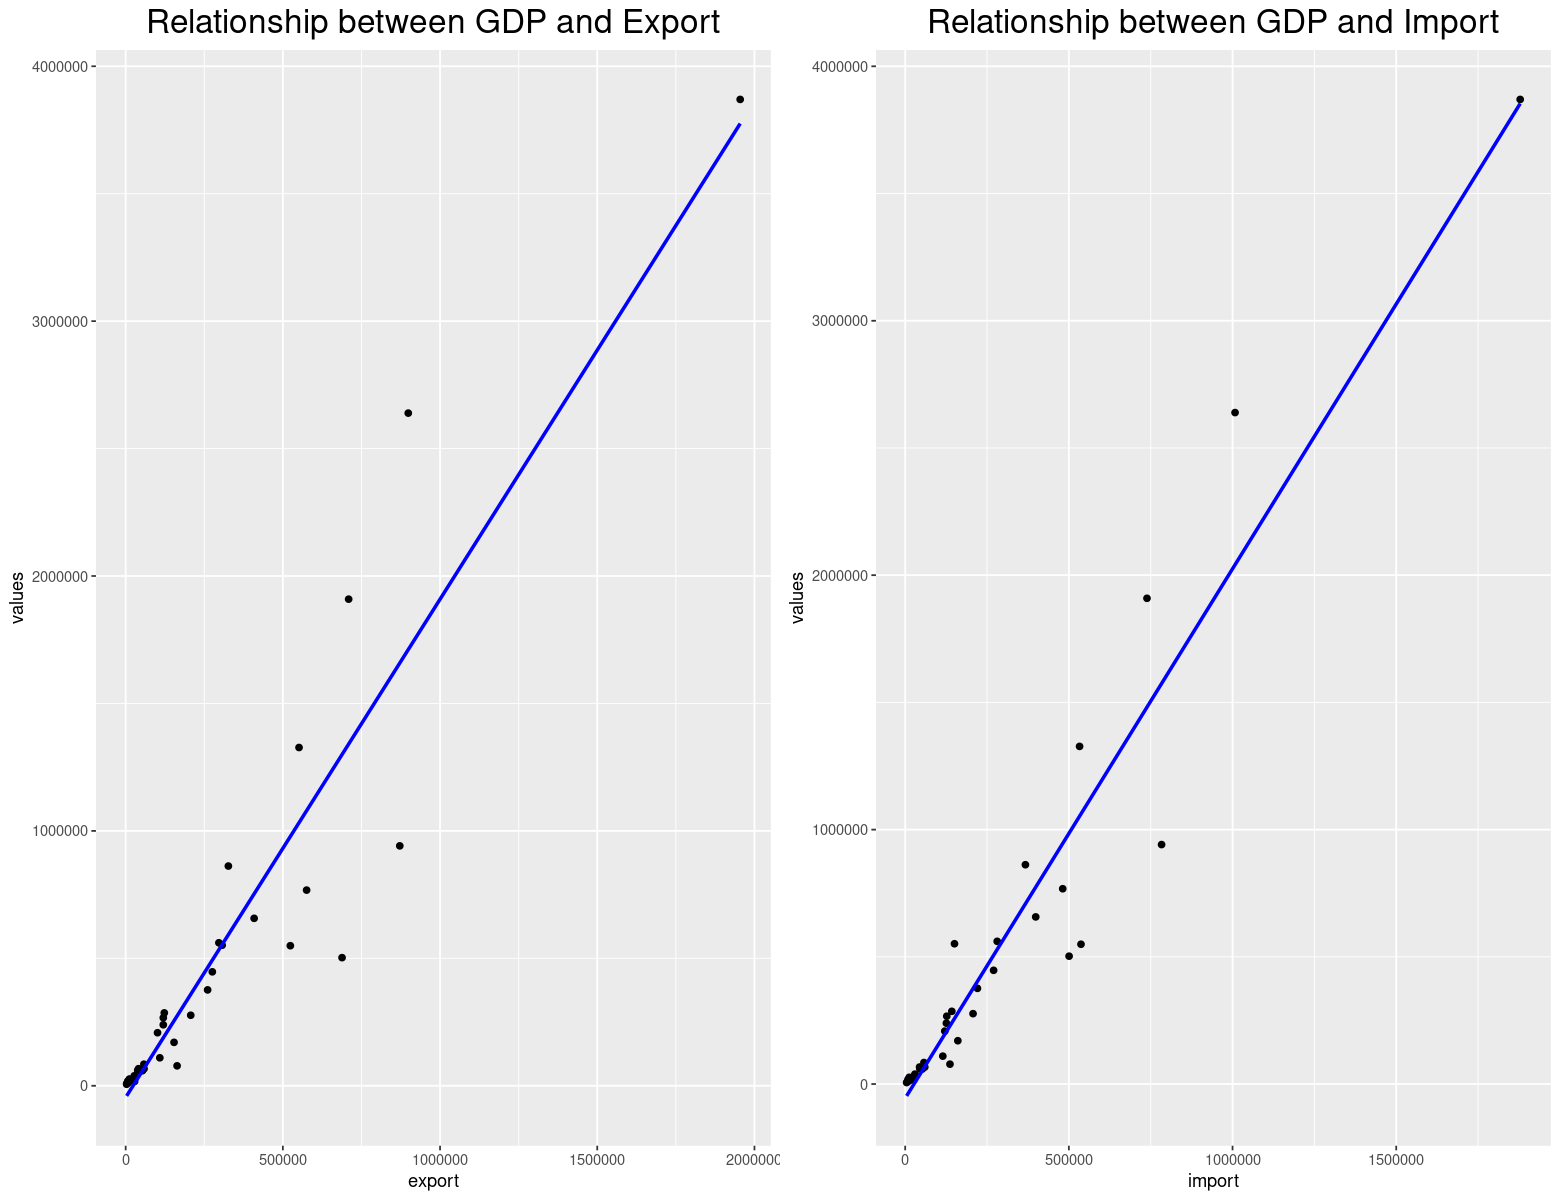

In [48]:
p3 <- ggplot(data_merged3, aes(x=export, y=values)) +
        geom_point() +
        stat_smooth(method="lm", formula=y~x, col="blue", se=F) +
        labs(title = "Relationship between GDP and Export")+
        theme(plot.title = element_text(size = 20, hjust = 0.5))

p4 <- ggplot(data_merged3, aes(x=import, y=values)) +
        geom_point() +
        stat_smooth(method="lm", formula=y~x, col="blue", se=F) +
        labs(title = "Relationship between GDP and Import")+
        theme(plot.title = element_text(size = 20, hjust = 0.5))

plot_grid(p3, p4, nrow=1)

Z grafu je vidět, že import a export dobře vysvětlují chování HDP (body leží relativně blízko lineární křivky). Nicméně, nemůžeme na základě grafu jednoznačně určit, který regresor lépe determinuje HDP.

In [49]:
fit.export = lm(values~export, data=data_merged3)
summary(fit.export)


Call:
lm(formula = values ~ export, data = data_merged3)

Residuals:
    Min      1Q  Median      3Q     Max 
-797045  -56804   27218   50695  927834 

Coefficients:
               Estimate  Std. Error t value Pr(>|t|)    
(Intercept) -45893.7878  58480.8387  -0.785    0.438    
export           1.9549      0.1254  15.592   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 287700 on 35 degrees of freedom
Multiple R-squared:  0.8742,	Adjusted R-squared:  0.8706 
F-statistic: 243.1 on 1 and 35 DF,  p-value: < 2.2e-16


Podle testu významnosti koeficientu v lineární regresi vidíme, že koeficient importu je významný na hladině významnosti 5%. Navíc, náš model má poměrně vysoký adjustovaný koeficient determinace, což nás motivuje ponechat tento regresor v našem datasetu.

In [50]:
fit.import = lm(values~import, data=data_merged3)
summary(fit.import)


Call:
lm(formula = values ~ import, data = data_merged3)

Residuals:
    Min      1Q  Median      3Q     Max 
-632754  -59380   27225   51613  597980 

Coefficients:
               Estimate  Std. Error t value Pr(>|t|)    
(Intercept) -55843.8417  45323.8548  -1.232    0.226    
import           2.0810      0.1009  20.617   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 223700 on 35 degrees of freedom
Multiple R-squared:  0.9239,	Adjusted R-squared:  0.9218 
F-statistic: 425.1 on 1 and 35 DF,  p-value: < 2.2e-16


Koeficient regresoru `import` je statisticky významný, protože jeho p-hodnota je velmi nízká (p-hodnota < 0.05). Proto můžeme předpokládat, že existuje lineární závislost mezi importem a hodnotou HDP. Navíc, ve srovnání s exportem má tento lineární model ještě vyšší adjusted R-squared skóre, což naznačuje, že import má silnější vliv na hodnotu HDP než export (to však budeme muset ověřit ještě jiným způsobem).

Jak i v případě exportu/importu se podíváme na vztahy mezi regresandem HDP a numerickým regresorem `salary`. Znázorníme tyto vztahy pomocí scatter plotů.

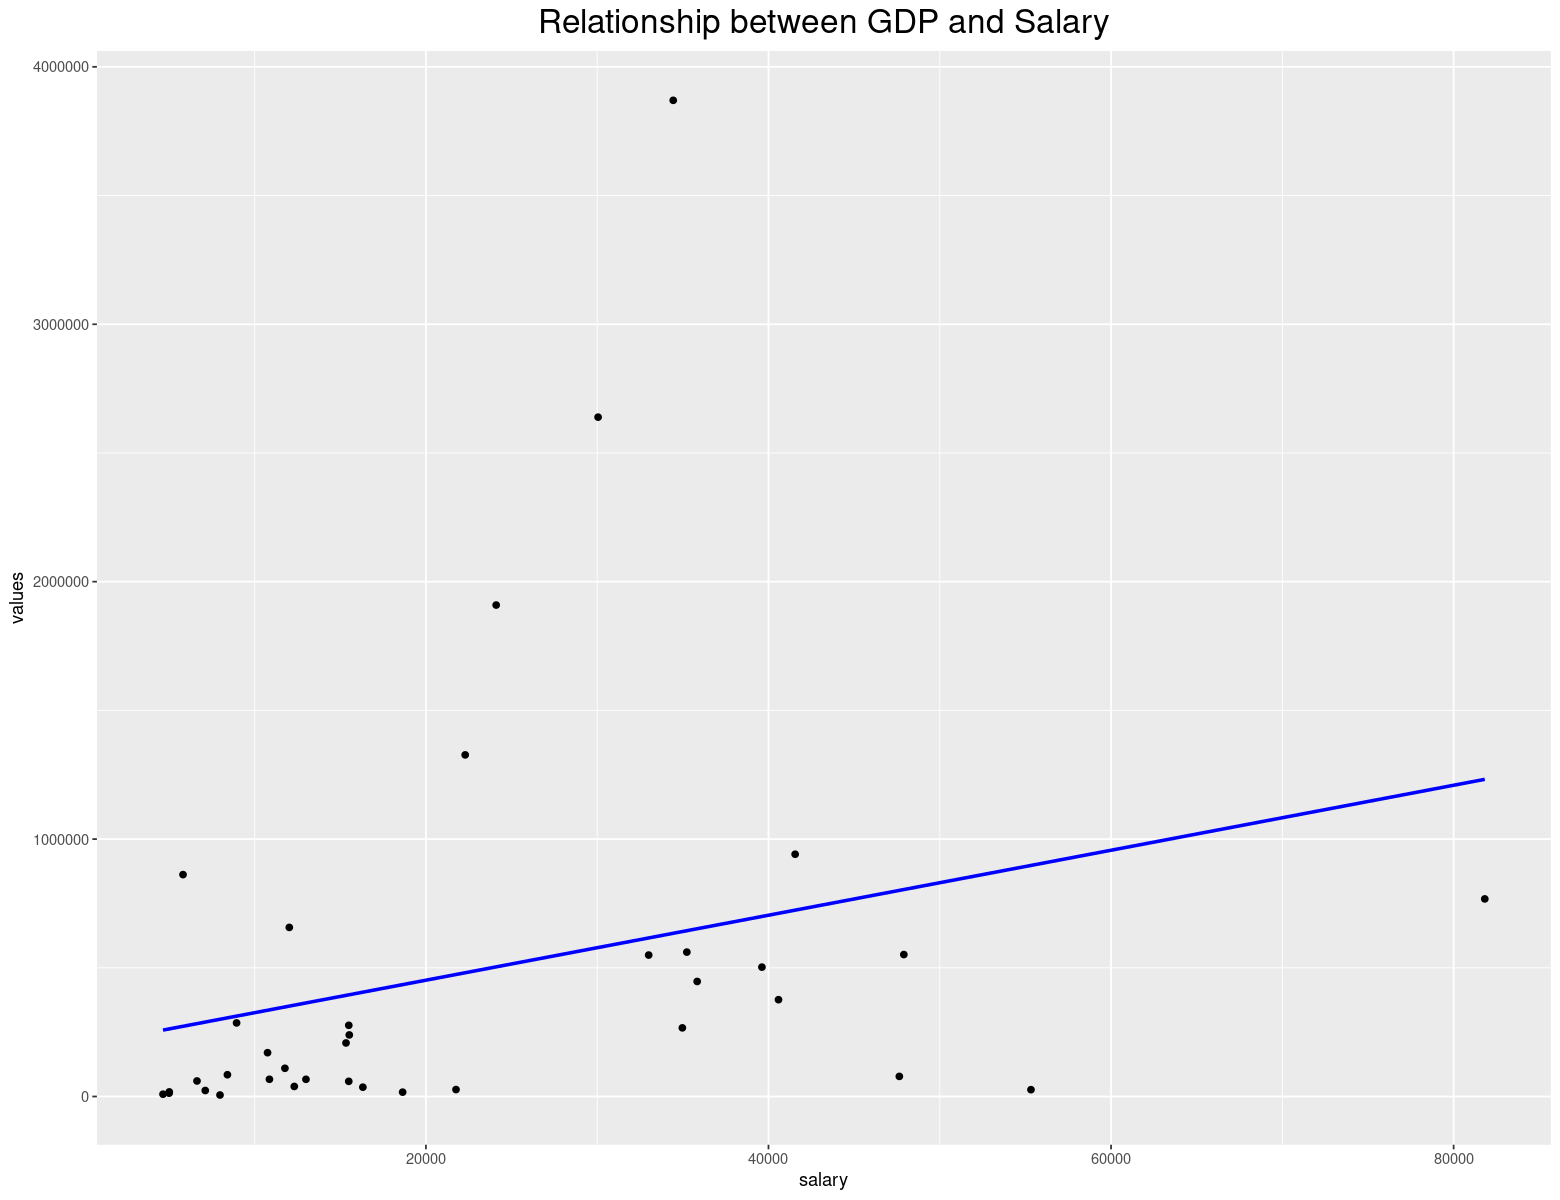

In [51]:
ggplot(data_merged3, aes(x=salary, y=values)) +
    geom_point() +
    stat_smooth(method="lm", formula=y~x, col="blue", se=F) +
    labs(title = "Relationship between GDP and Salary")+
    theme(plot.title = element_text(size = 20, hjust = 0.5))

Z grafu je patrná pozitivní korelace mezi mzdou a HDP. Nicméně, také jsou viditelná odlehlá pozorování, která mohou významně ovlivnit směr křivky, což je nežádoucí. Pro další zkoumání významnosti tohoto regresoru provedeme další testy.

In [52]:
fit.salary = lm(values~salary, data=data_merged3)
summary(fit.salary)


Call:
lm(formula = values ~ salary, data = data_merged3)

Residuals:
    Min      1Q  Median      3Q     Max 
-871231 -315757 -238273  -83152 3235820 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)
(Intercept) 199365.924 214794.990   0.928     0.36
salary          12.623      7.473   1.689     0.10

Residual standard error: 779800 on 35 degrees of freedom
Multiple R-squared:  0.07537,	Adjusted R-squared:  0.04895 
F-statistic: 2.853 on 1 and 35 DF,  p-value: 0.1001


Jak vidíme, p-hodnota je menší než standardní hladina významnosti (5 %), což znamená, že nezamítáme nulovou hypotézu. V tomto konkrétním případě to znamená, že koeficient regresoru "salary" nemá významný vliv na hodnotu HDP. Adjustovaný koeficient determinace je také poměrně malý ve srovnání s jinými příznaky. 

In [53]:
fit.salary_pop = lm(values~salary+population, data=data_merged3)
summary(fit.salary_pop)


Call:
lm(formula = values ~ salary + population, data = data_merged3)

Residuals:
     Min       1Q   Median       3Q      Max 
-1495300   -43120    31374    86735  1249265 

Coefficients:
                  Estimate     Std. Error t value Pr(>|t|)    
(Intercept) -250187.068725  111022.380436  -2.253  0.03079 *  
salary           12.771217       3.584758   3.563  0.00111 ** 
population        0.029206       0.002687  10.868 1.33e-12 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 374000 on 34 degrees of freedom
Multiple R-squared:  0.7933,	Adjusted R-squared:  0.7812 
F-statistic: 65.26 on 2 and 34 DF,  p-value: 2.287e-12


Ale pokud se pokusíme postavit lineární model, ve kterém kromě platu (`salary`) použijeme také populace (`population`) jako další regresor, uvidíme, že statistická významnost tohoto parametru vzhledem k HDP se zlepšila, což vypadá dost logicky, protože na HDP ovlivňuje ne průměrná mzda jednotlivých osob, ale součet všech mzdových příjmů. Proto ponecháme tento příznak pro další průzkum.

### Testy korelace 


> Pomocí vhodných testů prozkoumejte závislosti mezi regresory.

Provedení testu korelace před lineární regresí je důležité z několika důvodů:

* Identifikace lineárního vztahu: Test korelace nám pomáhá určit, zda mezi proměnnými existuje lineární vztah. Pokud není nalezena statisticky významná korelace, může to naznačovat, že lineární regrese nebude adekvátním modelem pro data (
častečně jsme se tímto již zabývali před pár kroky).

* Detekce multikolinearity: Korelace mezi regresory nám poskytuje informace o jejich vzájemné korelaci. V případě vysoké korelace mezi regresory může být problém s multicolinearity, což znamená, že regresory jsou vzájemně silně závislé. Pokud jsou regresory korelované, je matice $\mathbf X^T\mathbf X$ špatně podmíněná a rozptyl odhadů regresních koeficientů příliš vysoký - tomu se chceme vyvarovat.

In [54]:
data <- data_merged3

Na začátku se podíváme na vztah mezi regresory `import` a `export`. Intuitivně se nám zdá, že by ty dva regresory měly být silně korelovány. Znázorníme tento vztah pomocí scatter plotu.

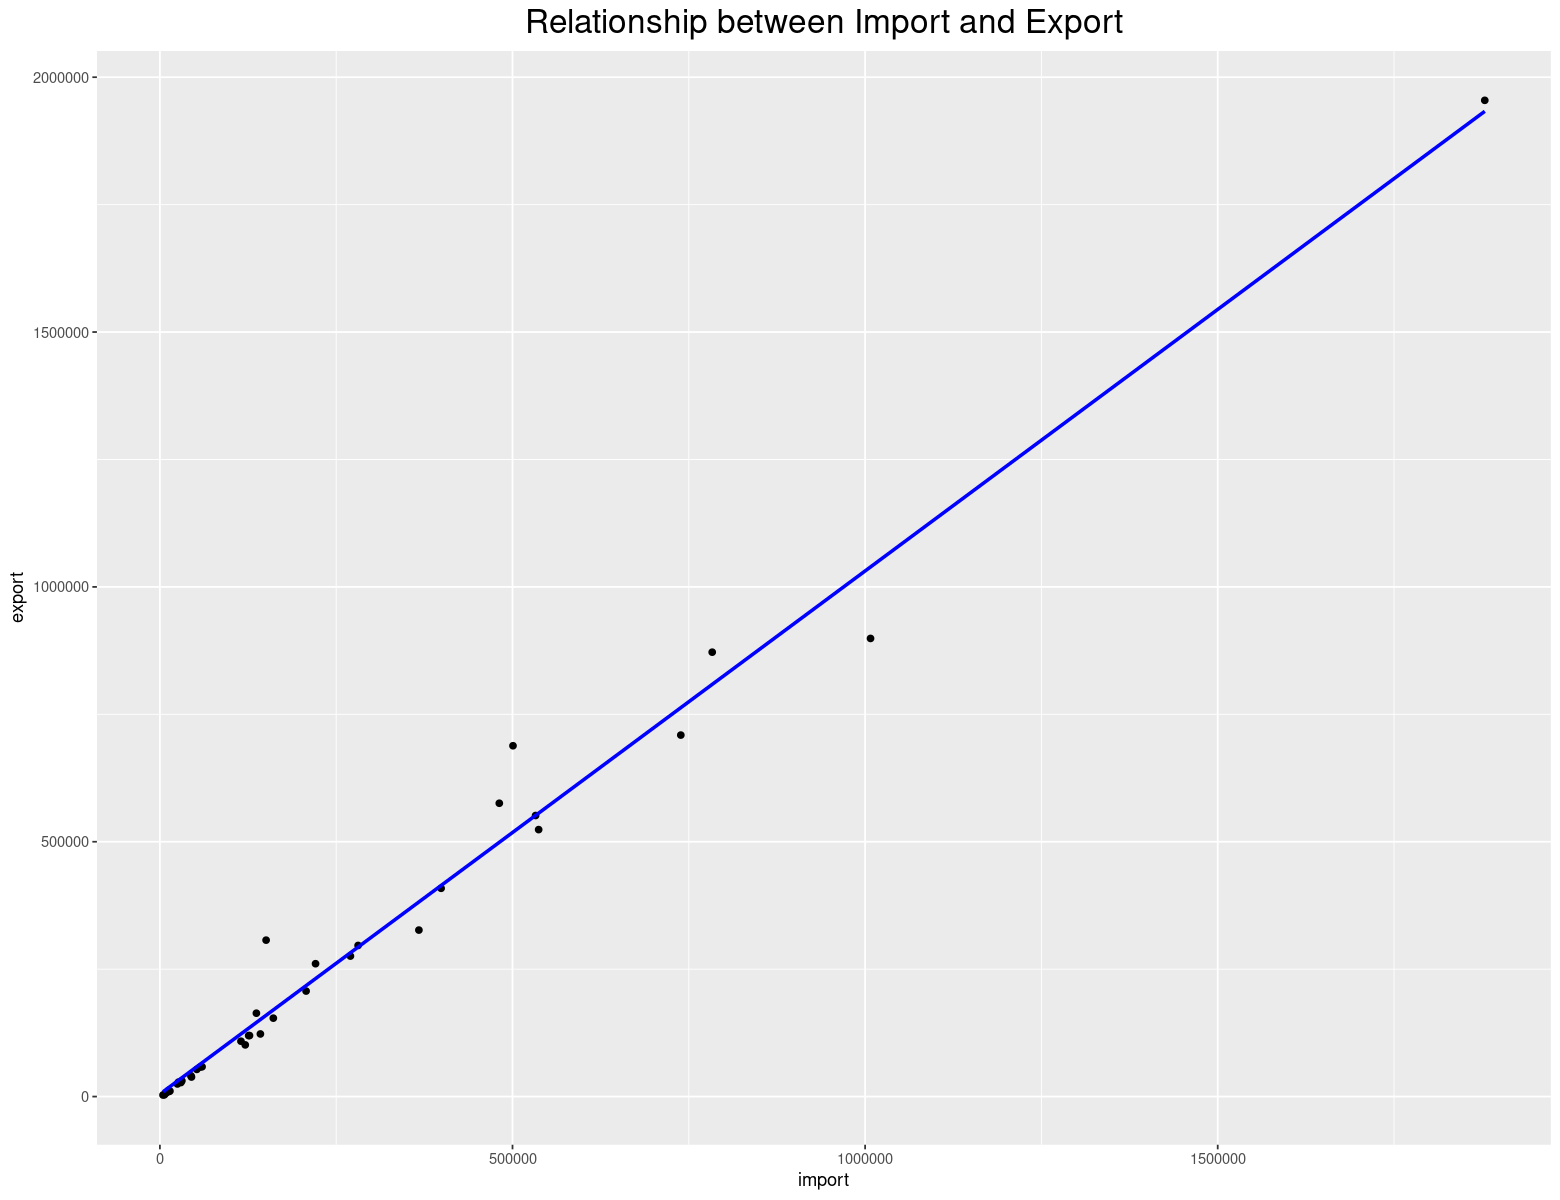

In [55]:
ggplot(data, aes(x=import, y=export)) +
    geom_point() +
    stat_smooth(method="lm", formula=y~x, col="blue", se=F) +
    labs(title = "Relationship between Import and Export")+
    theme(plot.title = element_text(size = 20, hjust = 0.5))

Z grafu pozorujeme silnou a pozitivní lineární korelaci mezi importem a exportem. Pro ověření této korelace provedeme vhodný test, nicméně máme tušení, že budeme muset některé z těchto regresorů odstranit z datasetu.

Pro provedení testu korelace je nezbytné nejprve ověřit předpoklady normality rozdělení jednotlivých regresorů a regresandu. Ověříme tyto předpoklady pomocí Shapiro-Wilkova testu na hladině významnosti 5%.

In [56]:
shapiro.test(data$import)
shapiro.test(data$export)
shapiro.test(data$population)
shapiro.test(data$values)


	Shapiro-Wilk normality test

data:  data$import
W = 0.68353, p-value = 0.0000001192



	Shapiro-Wilk normality test

data:  data$export
W = 0.69364, p-value = 0.0000001711



	Shapiro-Wilk normality test

data:  data$population
W = 0.63229, p-value = 0.00000002116



	Shapiro-Wilk normality test

data:  data$values
W = 0.62192, p-value = 0.0000000152


**Závěr**: Žádná z proměnných nesplňuje předpoklad normality (Nepodařilo se zamítnout $\mathbf{H_0}$). Proto budeme nadále používat Spearmanův korelační koeficient, který je neparametrickou alternativou k Pearsonovu korelačnímu koeficientu, zejména při porušení předpokladu normality ve výběru.

Provedeme Spearmanův korelační test mezi proměnnými `import` a `export` v našem datasetu.

In [57]:
cor.test(data$import, data$export, method='spearman')


	Spearman's rank correlation rho

data:  data$import and data$export
S = 64, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.9924135 


Výsledek testu naznačuje, že existuje silná pozitivní korelace mezi hodnotami importu a exportu (hodnota korelačního koeficientu je 0.99). Pro řešení multikolinearity, která nastává při vysoké korelaci mezi regresory v lineární regresi, existuje několik možností, v našem případě postupujeme takto - odstraníme jeden z korelovaných regresorů z modelu.</br>
Nyní je naším úkolem určit, který z regresorů bychom měli ponechat. Podívejme se na korelaci mezi regresandem a každým z těchto dvou regresorů.

In [58]:
cor.test(data$import, data$values, method='spearman')
cor.test(data$export, data$values, method='spearman')


	Spearman's rank correlation rho

data:  data$import and data$values
S = 250, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.9703651 



	Spearman's rank correlation rho

data:  data$export and data$values
S = 240, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.9715505 


Výsledky jsou téměř stejné. Oba regresory mají silnou pozitivní korelaci s regresandem. Pro další průzkum použijeme Variance Inflation Factor (VIF), který nám poskytne přehled o míře závislosti každého regresoru na ostatních. Spočítáme VIF pro regresory `import`, `export`, `salary` a `population`.

In [59]:
data.frame(vif(lm(values~import+export+salary+population, data=data)))

vif.lm.values...import...export...salary...population..data...data..
import     101.777993                                                          
export      91.370304                                                          
salary       1.645638                                                          
population   3.729134

Vyšší hodnoty VIF naznačují vyšší míru kolinearit, což může být problém. Obecně se doporučuje, aby hodnoty VIF byly nižší než 5. V našem případě pro regresory `import` a `export` jsou tyto hodnoty mnohonásobně vyšší. To jen potvrzuje náš předpoklad o tom, že potřebujeme odstranit jeden z těchto dvou regresorů. Na základě toho, že export měl o trochu větší hodnotu korelace s vysvětlovanou proměnnou HDP než import a také má nižší Variance Inflation Factor, ponecháme tento příznak a pokusíme se odstranit příznak `import` a podívat se, co se stane.

In [60]:
data_noImport <- data
data_noImport$import <- NULL

In [61]:
data.frame(vif(lm(values~export+salary+population, data=data_noImport)))

vif.lm.values...export...salary...population..data...data_noImport..
export     3.215295                                                            
salary     1.547083                                                            
population 2.675536

Nyní jsou všechny hodnoty VIF menší než 5, což nás uspokojuje. Proto budeme nadále používat příznak export.

Podívejme se na vyběrovou korelační matici mezi regresory(a regresandem). Opět použijeme Spearmanův korelační koeficient.

In [62]:
data <- data_noImport
cor(data.frame(data$export, data$salary, data$population, data$values), method='spearman')

data.export data.salary data.population data.values
data.export     1.0000000   0.58724514  0.78781413      0.9715505  
data.salary     0.5872451   1.00000000  0.09174964      0.5111427  
data.population 0.7878141   0.09174964  1.00000000      0.8707918  
data.values     0.9715505   0.51114272  0.87079184      1.0000000

Celkově vypadá tato matice pro nás dobře. Population a Export jsou silně korelovány s hodnotou HDP, což se nám líbí. Jediný problém je v tom, že Population a Export mají docela silnou korelaci mezi sebou. Nicméně, Variance Inflation Factor nám umožňuje (všechny hodnoty jsou menší než 5) ponechat oba tyto regresory, takže mu budeme věřit.

### Prezentace regresorů

> Prezentujte důležité vlastnosti zvolených ukazatelů číselně i graficky.

Nakresleme histogramy rozdělení každého ze spojitých regresorů.

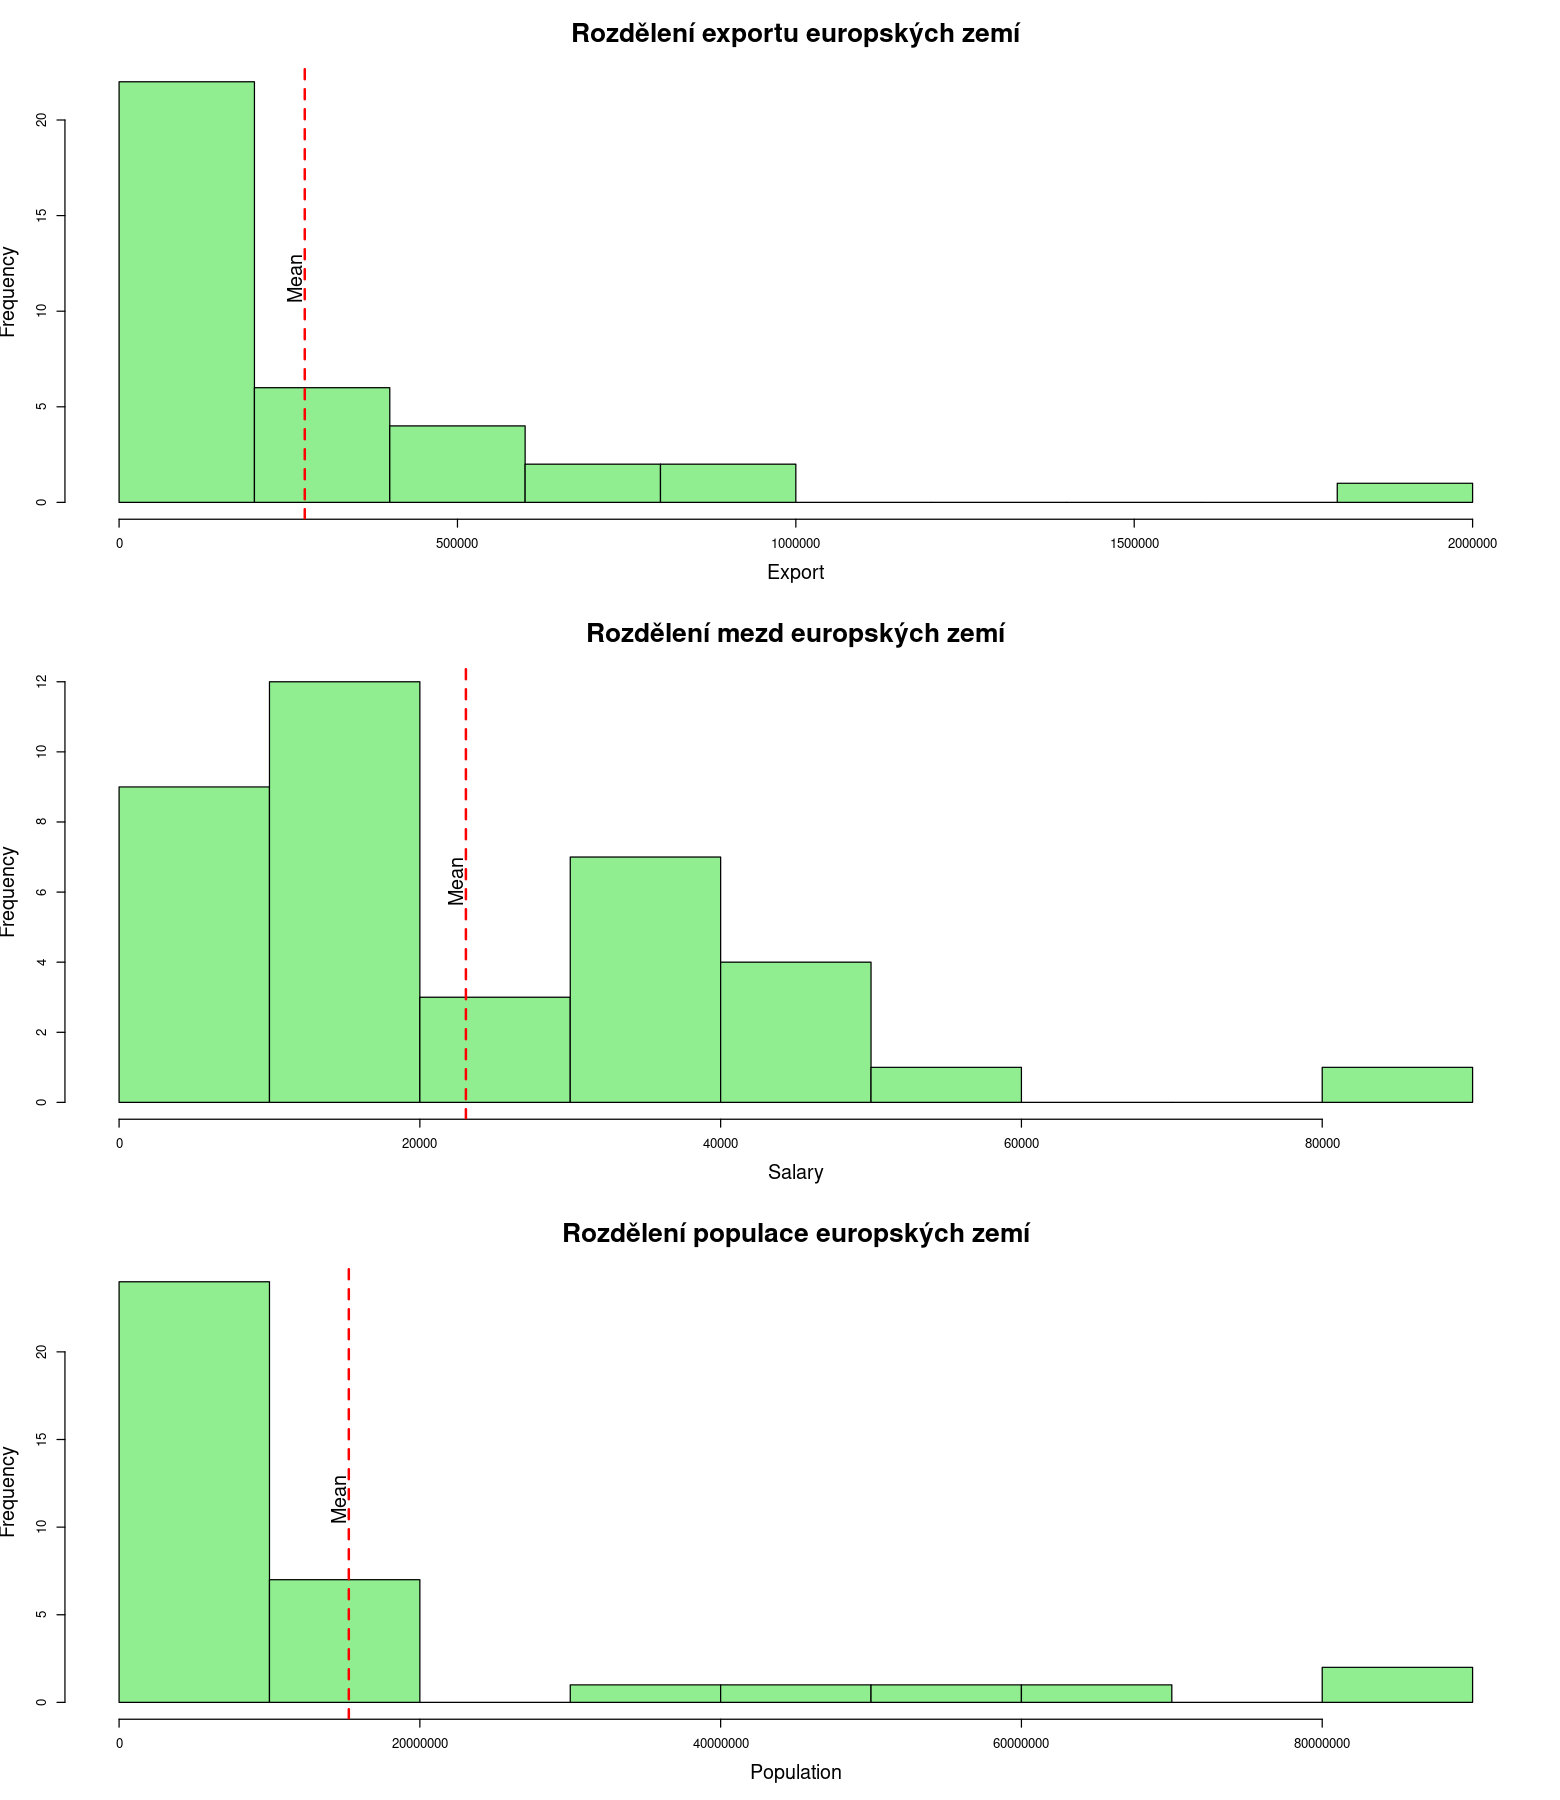

In [63]:
options(width=200, repr.plot.width=13, repr.plot.height=15) 
par(mfrow = c(3,1))

hist(data$export, prob=F, col="Lightgreen", main="Rozdělení exportu europských zemí", xlab = "Export", cex.lab=1.5, cex.main=2)
abline(v = mean(data$export), col = "red", lty = 2, lwd=2)
text(mean(data$export), 13, "Mean", pos = 2, srt = 90, cex=1.5)

hist(data$salary, prob=F, col="Lightgreen", main="Rozdělení mezd europských zemí", xlab = "Salary", cex.lab=1.5, cex.main=2)
abline(v = mean(data$salary), col = "red", lty = 2, lwd=2)
text(mean(data$salary), 7, "Mean", pos = 2, srt = 90, cex=1.5)

hist(data$population, prob=F, col="Lightgreen", main="Rozdělení populace europských zemí", xlab = "Population", cex.lab=1.5, cex.main=2)
abline(v = mean(data$population), col = "red", lty = 2, lwd=2)
text(mean(data$population), 13, "Mean", pos = 2, srt = 90, cex=1.5)

Každý z histogramů ukazuje sešikmenost vpravo a koncentraci dat kolem výběrového průměru, což je podobné tomu, co jsme viděli u regresandu.

Nyní vykreslíme sloupcový graf pro jediný kategorický příznak, který budeme používat v našem modelu - region, a podíváme se na četnosti každého z regionů.

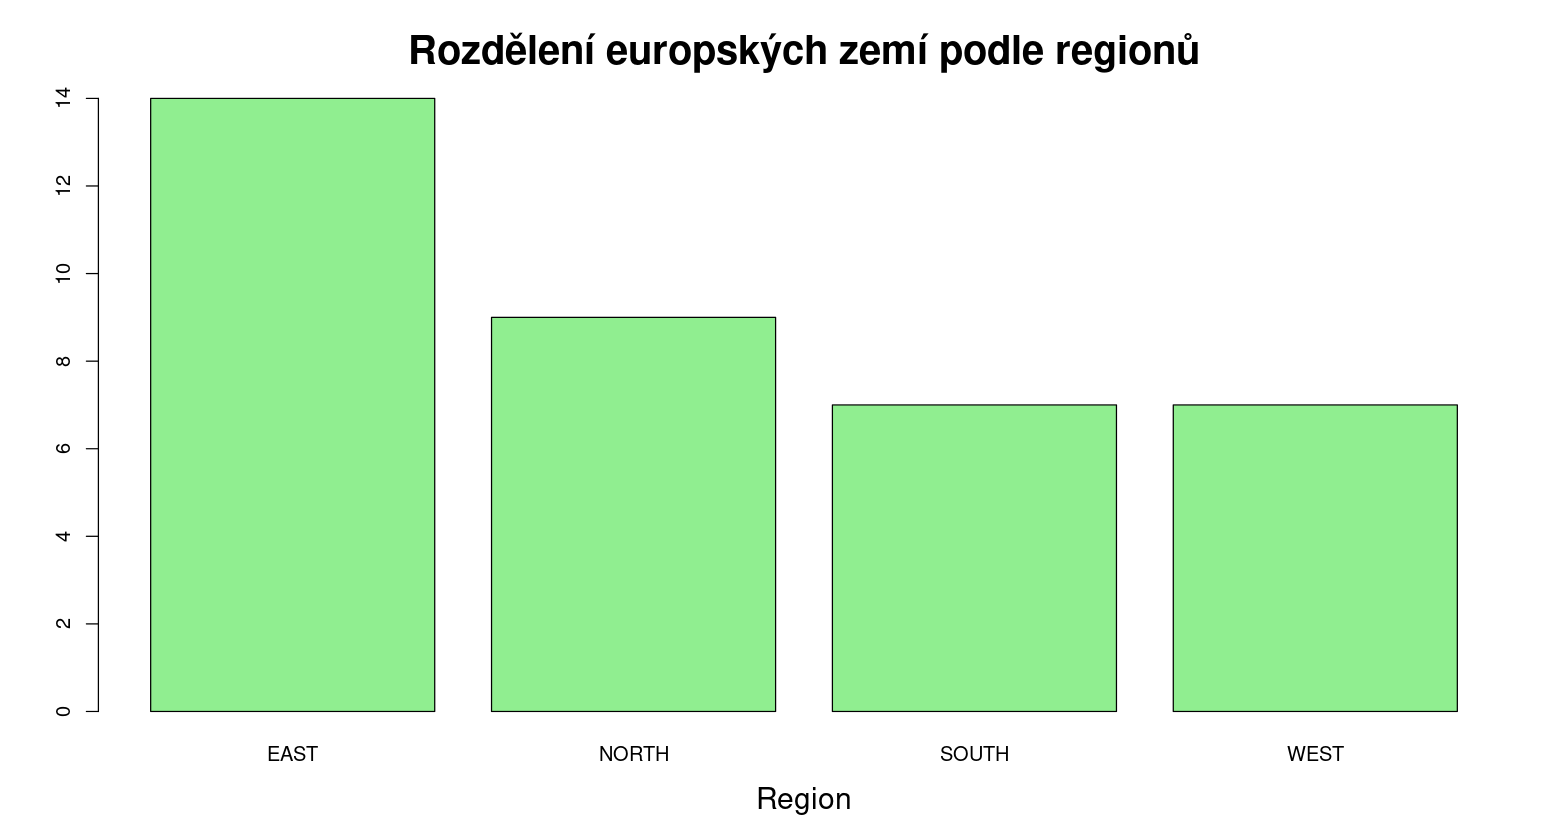

In [64]:
options(width=200, repr.plot.width=13, repr.plot.height=7) 
barplot(table(data$region), col="Lightgreen", main="Rozdělení europských zemí podle regionů", 
        xlab = "Region", cex.lab=1.5, cex.main=2)

Největší počet států se nachází ve východním regionu.

Pomocí funkce `summary()` prezentujeme základní deskriptivní statistiky našich regresorů.

In [65]:
summary(data)

     geo                values          population         region       export            salary     
 Length:37          Min.   :   5797   Min.   :  376248   EAST :14   Min.   :   3054   Min.   : 4651  
 Class :character   1st Qu.:  39062   1st Qu.: 2107180   NORTH: 9   1st Qu.:  30936   1st Qu.:10755  
 Mode  :character   Median : 208030   Median : 5873420   SOUTH: 7   Median : 119716   Median :15526  
                    Mean   : 490462   Mean   :15275458   WEST : 7   Mean   : 274369   Mean   :23061  
                    3rd Qu.: 551409   3rd Qu.:10516707              3rd Qu.: 326650   3rd Qu.:34972  
                    Max.   :3869900   Max.   :86735919              Max.   :1954622   Max.   :81818  

Všechny naše spojité regresory mají podobnou vlastnost, že průměr každého z nich je větší (ve dvou z tří případů násobně větší) než medián, což jsme mohli pozorovat i u regresandu. Celkově lze říci, že pomocí grafické a číselné reprezentace můžeme pozorovat, že vizualně rozdělení regresorů vypadá podobně jako u regresandu.

## Úloha 3

### Lineární model

> Pomocí lineárního regresního modelu nebo jeho variant zkoumejte závislost HDP na všech regresorech.

Nejprve se pokusíme použít lineární model se všemi regresory, ale bez interakcí.

In [66]:
fit.lin <- lm(values~export+population+region+salary, data=data_noImport)
summary(fit.lin)


Call:
lm(formula = values ~ export + population + region + salary, 
    data = data_noImport)

Residuals:
    Min      1Q  Median      3Q     Max 
-595248  -34266   37850   77318  596226 

Coefficients:
                 Estimate    Std. Error t value     Pr(>|t|)    
(Intercept) -85334.275480  71065.921989  -1.201     0.239233    
export           1.400929      0.195532   7.165 0.0000000569 ***
population       0.012639      0.002931   4.313     0.000161 ***
regionNORTH  45870.321591 124040.846062   0.370     0.714129    
regionSOUTH  -6681.406151 119200.319230  -0.056     0.955672    
regionWEST   34741.850102 174996.114038   0.199     0.843970    
salary          -0.785059      3.594409  -0.218     0.828588    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 220500 on 30 degrees of freedom
Multiple R-squared:  0.9366,	Adjusted R-squared:  0.924 
F-statistic:  73.9 on 6 and 30 DF,  p-value: < 2.2e-16


Z jednoduchého lineárního modelu jsme si všimli, že významnými parametry v modelu jsou `export` a `populace`, zatímco region a mzda nejsou statisticky významné a mají obrovskou standardní chybu. Nicméně, i přes jednoduchost modelu dosahuje vysokého adjustovaného koeficientu determinace, což naznačuje dobrou vysvětlující schopnost modelu.

> Pomocí vhodných nástrojů se pokuste najít finální (pod-)model, který chování HDP dobře vysvětluje, ale neobsahuje nevýznamné komponenty. Prakticky interpretujte získané výsledky.

Použijeme metodu `step()`, která na základě Akaikeho informačního kritéria sestaví nejvhodnější model pro lineární regresi.

In [67]:
step(lm(values~1, data=data_noImport), scope=list(lower=~1,upper=~export*population*region*salary))

Start:  AIC=1006.78
values ~ 1

             Df      Sum of Sq            RSS     AIC
+ export      1 20119981761299  2896551765059  932.09
+ population  1 16484290170539  6532243355819  962.18
+ region      3  7339542368483 15676991157875  998.58
+ salary      1  1734653825825 21281879700533 1005.88
<none>                         23016533526358 1006.78

Step:  AIC=932.09
values ~ export

             Df      Sum of Sq            RSS     AIC
+ population  1  1428732335002  1467819430057  908.94
+ salary      1   325986876660  2570564888399  929.68
<none>                          2896551765059  932.09
+ region      3   377404937651  2519146827407  932.93
- export      1 20119981761299 23016533526358 1006.78

Step:  AIC=908.94
values ~ export + population

                    Df     Sum of Sq           RSS    AIC
+ export:population  1  421627508249 1046191921808 898.41
<none>                               1467819430057 908.94
+ salary             1      49992736 1467769437320 910.94
+ r


Call:
lm(formula = values ~ export + population + salary + region + 
    export:population + population:salary + export:salary + export:region + 
    salary:region + population:region + export:salary:region + 
    export:population:salary + population:salary:region + export:population:region + 
    export:population:salary:region, data = data_noImport)

Coefficients:
                         (Intercept)                                export                            population                                salary                           regionNORTH  
                           1.308e+04                            -7.124e-01                            -6.491e-03                            -1.924e+00                            -3.724e+04  
                         regionSOUTH                            regionWEST                     export:population                     population:salary                         export:salary  
                          -2.040e+06                    

Dostali jsme nejlepší model podle AIC, nyní bychom měli provést jeho fitting a podívat se na výsledky.

In [68]:
fit.step <- lm(formula = values ~ export + population + salary + region + 
                         export:population + population:salary + export:salary + export:region + 
                         salary:region + population:region + export:salary:region + 
                         export:population:salary + population:salary:region + export:population:region + 
                         export:population:salary:region, data = data_noImport)
summary(fit.step)


Call:
lm(formula = values ~ export + population + salary + region + 
    export:population + population:salary + export:salary + export:region + 
    salary:region + population:region + export:salary:region + 
    export:population:salary + population:salary:region + export:population:region + 
    export:population:salary:region, data = data_noImport)

Residuals:
   Min     1Q Median     3Q    Max 
-15306      0      0   1496  12290 

Coefficients: (2 not defined because of singularities)
                                       Estimate Std. Error t value Pr(>|t|)  
(Intercept)                           1.308e+04  1.978e+04   0.661   0.5296  
export                               -7.124e-01  6.052e-01  -1.177   0.2776  
population                           -6.491e-03  8.815e-03  -0.736   0.4855  
salary                               -1.924e+00  2.066e+00  -0.931   0.3828  
regionNORTH                          -3.724e+04  4.455e+04  -0.836   0.4308  
regionSOUTH                         

Na první pohled model, který jsme navrhli pomocí metody `step()`, má velmi vysoký adjustovaný koeficient determinace. Nicméně, obsahuje mnoho nevýznamných parametrů a v případě jedné interakce nemáme dostatek pozorování. Přesto je tento model dobrým výchozím bodem, který můžeme zkusit zjednodušit a vylepšit.

In [69]:
fit.step.reduced <- lm(formula = values ~ export:region + 
                         salary:region + population:region + export:salary:region + 
                         population:salary:region + export:population:region, data = data_noImport)
summary(fit.step.reduced)


Call:
lm(formula = values ~ export:region + salary:region + population:region + 
    export:salary:region + population:salary:region + export:population:region, 
    data = data_noImport)

Residuals:
     Min       1Q   Median       3Q      Max 
-18110.7  -3818.5    431.4   4214.6  14002.3 

Coefficients:
                                Estimate Std. Error t value  Pr(>|t|)    
(Intercept)                   -9.657e+03  1.612e+04  -0.599  0.560343    
export:regionEAST              6.194e-02  4.970e-01   0.125  0.902882    
export:regionNORTH            -3.039e+00  5.197e-01  -5.846 0.0000788 ***
export:regionSOUTH             1.623e+01  3.610e+00   4.497  0.000731 ***
export:regionWEST              4.439e-01  1.157e-01   3.838  0.002361 ** 
regionEAST:salary              2.858e-01  1.806e+00   0.158  0.876885    
regionNORTH:salary             9.982e-02  4.035e-01   0.247  0.808794    
regionSOUTH:salary             6.758e+00  2.145e+00   3.151  0.008365 ** 
regionWEST:salary         

Po zjednodušení modelu jsme dosáhli přijatelného výsledku, protože téměř všechny regresory jsou významné a adjustovaný koeficient determinace se snížil pouze o 0,0001. Jedinou nevýhodou je, že intercept není statisticky významný a má vysokou standardní chybu. Pro další porovnání mezi modely můžeme použít funkci `anova()`.

Porovnáme modely příkazem `anova()` pomocí `F-testu`.

In [70]:
anova(fit.step.reduced, fit.step)

Res.Df RSS        Df Sum of Sq  F        Pr(>F)   
1 12     1970656540 NA         NA       NA        NA
2  7      773290763  5 1197365777 2.167764 0.1707484

Na standardní hladině významnosti 5% nebyl nalezen statisticky významný rozdíl mezi modely, a proto preferujeme ten jednodušší (`fit.step.reduced`).

### Logaritmický model

Teď bychom chtěli použít některou z variant lineární regrese. Abychom zjistili, který model je vhodný použít, pojďme sledovat rezidua našeho lineárního modelu.

Na začátku nakreslíme grafy závislosti hodnoty HDP na exportu a hodnoty HDP na počtu obyvatel ve státech. Na těchto grafech se podíváme, jak se odchylují původní hodnoty HDP od naší regresní přímky.

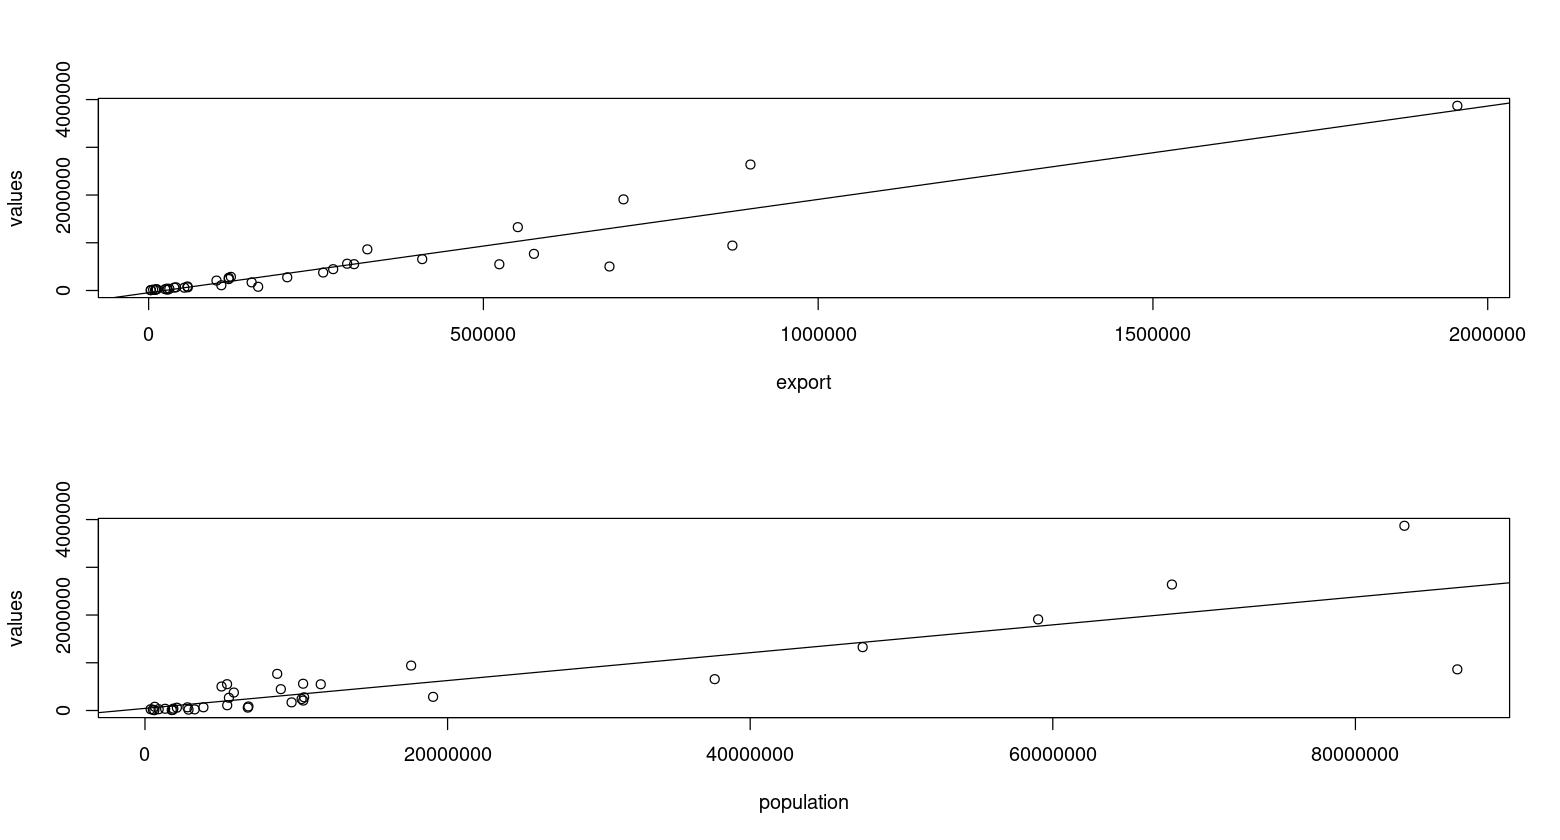

In [71]:
par(mfrow=c(2,1))

plot(values~export,data=data_noImport)
abline(lm(values~export,data=data_noImport))

plot(values~population,data=data_noImport)
abline(lm(values~population,data=data_noImport))

Jak můžeme vidět na grafech, s rostoucí hodnotou regresoru se zvětšuje vzdálenost mezi předpovídanou hodnotou a skutečnou hodnotou, což nám dává důvod k podezření, že naše rezidua nejsou homoskedastická.

Ověříme naši domněnku o homoskedasticitě reziduí pomocí **Breusch-Paganova** testu. Také vykreslíme graf "Scale-Location", který zobrazuje standardizované rezidua (rezidua, která jsou upravena tak, aby měla střední hodnotu 0 a standardní odchylku 1) v závislosti na předpovězených hodnotách. Tento graf slouží k posouzení **homoskedasticity**.


 Breusch Pagan Test for Heteroskedasticity
 -----------------------------------------
 Ho: the variance is constant            
 Ha: the variance is not constant        

               Data                
 ----------------------------------
 Response : values 
 Variables: fitted values of values 

           Test Summary            
 ----------------------------------
 DF            =    1 
 Chi2          =    26.81018 
 Prob > Chi2   =    0.0000002244518 

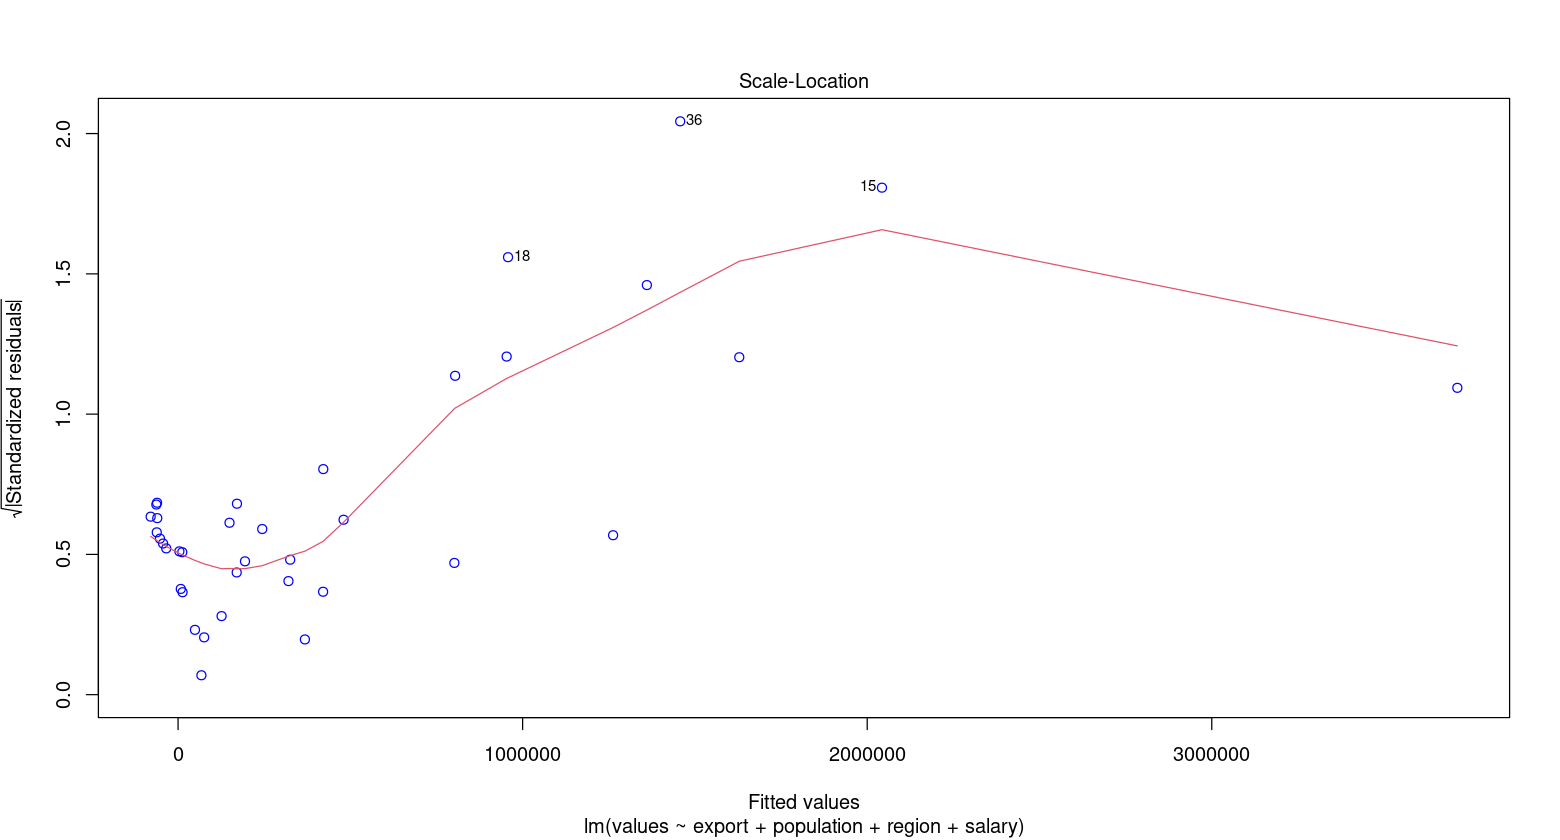

In [72]:
plot(fit.lin, which=3, col=c("blue"))
ols_test_breusch_pagan(fit.lin)

Zamítáme nulovou hypotézu o konstantním rozptylu reziduí na hladině významnosti 5% ve prospěch alternativy, že rozptyl není konstantní.

Takže naše rezidua jsou heteroskedastická. V tomto případě bychom uvažovali o vhodné transformaci dat, která by stabilizovala rozptyl. Jako možnou transformaci může sloužit logaritmická transformace. Z grafů, které jsme výše vykreslili, můžeme pozorovat, že rezidua rostou s vysvětlující proměnnou, což je dobrým důvodem pro použití právě tohoto modelu.

In [73]:
fit.log <- lm(log(values)~export+population+region+salary,data=data_noImport)
summary(fit.log)


Call:
lm(formula = log(values) ~ export + population + region + salary, 
    data = data_noImport)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.0752 -0.5746  0.2367  0.6302  1.1482 

Coefficients:
                  Estimate     Std. Error t value Pr(>|t|)    
(Intercept) 10.26652702246  0.31771862695  32.313  < 2e-16 ***
export       0.00000131081  0.00000087418   1.499  0.14420    
population   0.00000003664  0.00000001310   2.796  0.00894 ** 
regionNORTH  0.17019473073  0.55455675792   0.307  0.76104    
regionSOUTH  0.08554270737  0.53291592789   0.161  0.87355    
regionWEST  -0.16477631547  0.78236549274  -0.211  0.83461    
salary       0.00003240452  0.00001606974   2.016  0.05278 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.9858 on 30 degrees of freedom
Multiple R-squared:  0.7148,	Adjusted R-squared:  0.6578 
F-statistic: 12.53 on 6 and 30 DF,  p-value: 0.0000004903


Dostáváme zatím poměrně zajímavé výsledky. Nejprve si můžeme všimnout, že v jednoduchém logaritmickém modelu je **adjustovaný koeficient determinace** menší, což naznačuje horší schopnost modelu zachytit strukturu dat. Překvapivé je, že významnou proměnnou je pouze populace, zatímco všechny ostatní proměnné mají malou standardní chybu, což naznačuje přesnější odhad koeficientů. Nicméně, je rozumné, protože malá změna koeficientu u regresoru s vysokým rozptylem by vedla k velké změně vysvětlované proměnné, zejména pokud byla použita ji logaritmická transformace. 
Abychom tomu předešli, můžeme zkusit stabilizovat rozptyl u všech numerických regresorů.

In [74]:
fit.log_advanced <- lm(log(values)~log(export)+log(population)+region+log(salary),data=data_noImport)
summary(fit.log_advanced)


Call:
lm(formula = log(values) ~ log(export) + log(population) + region + 
    log(salary), data = data_noImport)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.15152 -0.06488 -0.01656  0.06575  0.20267 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)     -9.241371   0.586709 -15.751 4.75e-16 ***
log(export)      0.338388   0.032558  10.393 1.85e-11 ***
log(population)  0.712020   0.029616  24.042  < 2e-16 ***
regionNORTH      0.138728   0.061429   2.258   0.0314 *  
regionSOUTH      0.009644   0.051988   0.186   0.8541    
regionWEST      -0.073564   0.074894  -0.982   0.3338    
log(salary)      0.631340   0.054740  11.533 1.49e-12 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.09757 on 30 degrees of freedom
Multiple R-squared:  0.9972,	Adjusted R-squared:  0.9966 
F-statistic:  1785 on 6 and 30 DF,  p-value: < 2.2e-16


Je skvělé vidět, že stabilizace rozptylu měla pozitivní dopad. **Adjustovaný koeficient determinace** se výrazně zvýšilo a všechny proměnné (včetně interceptu) jsou významné, přičemž žádná z nich nemá standardní chybu vyšší než 1. Zdá se, že jsme dosáhli dobrého logaritmického modelu. Můžeme pokračovat a použít metodu `step` pro nalezení ještě lepšího modelu.

In [75]:
step(lm(log(values)~1, data=data_noImport), 
     scope=list(lower=~1,upper=~log(export)*log(population)*region*log(salary)))

Start:  AIC=39.6
log(values) ~ 1

                  Df Sum of Sq     RSS     AIC
+ log(export)      1    95.733   6.495 -60.376
+ log(population)  1    77.354  24.874 -10.692
+ log(salary)      1    30.252  71.976  28.621
+ region           3    32.302  69.926  31.551
<none>                         102.228  39.603

Step:  AIC=-60.38
log(values) ~ log(export)

                  Df Sum of Sq     RSS     AIC
+ log(population)  1     4.021   2.474 -94.091
+ log(salary)      1     0.557   5.938 -61.690
<none>                           6.495 -60.376
+ region           3     0.325   6.170 -56.272
- log(export)      1    95.733 102.228  39.603

Step:  AIC=-94.09
log(values) ~ log(export) + log(population)

                              Df Sum of Sq     RSS      AIC
+ log(salary)                  1    2.0161  0.4577 -154.517
+ region                       3    0.9218  1.5520 -105.340
+ log(export):log(population)  1    0.2374  2.2364  -95.823
<none>                                      2.4738  


Call:
lm(formula = log(values) ~ log(export) + log(population) + log(salary) + 
    region + log(population):log(salary), data = data_noImport)

Coefficients:
                (Intercept)                  log(export)              log(population)                  log(salary)                  regionNORTH                  regionSOUTH  
                 -14.404720                     0.321676                     1.051020                     1.153101                     0.135114                    -0.007553  
                 regionWEST  log(population):log(salary)  
                  -0.051483                    -0.032986  


Dostali jsme nejlepší model podle AIC, nyní bychom měli provést jeho fitting a podívat se na výsledky.

In [76]:
fit.log.step <- lm(formula = log(values) ~ log(export) + log(population) + log(salary) + 
                                            region + log(population):log(salary), data = data_noImport)
summary(fit.log.step)


Call:
lm(formula = log(values) ~ log(export) + log(population) + log(salary) + 
    region + log(population):log(salary), data = data_noImport)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.13804 -0.05296 -0.01290  0.05546  0.21341 

Coefficients:
                              Estimate Std. Error t value Pr(>|t|)    
(Intercept)                 -14.404720   2.568555  -5.608 4.69e-06 ***
log(export)                   0.321676   0.031978  10.059 5.77e-11 ***
log(population)               1.051020   0.167007   6.293 7.15e-07 ***
log(salary)                   1.153101   0.258651   4.458 0.000114 ***
regionNORTH                   0.135114   0.058384   2.314 0.027938 *  
regionSOUTH                  -0.007553   0.050090  -0.151 0.881186    
regionWEST                   -0.051483   0.071953  -0.716 0.480011    
log(population):log(salary)  -0.032986   0.016018  -2.059 0.048546 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.09

Metoda `step` tedy přibližně navrhla stejný model jako jsme měli v předchozím kroku, s přidáním jedné proměnné (interakce populace a mzdy). Všechny koeficienty jsou významné a **adjustovaný koeficient determinace** se mírně zvýšil. Porovnáme modely(`fit.log_advanced` a `fit.log.step`) příkazem `anova()` pomocí F-testu.

In [77]:
anova(fit.log_advanced, fit.log.step)

Res.Df RSS       Df Sum of Sq  F        Pr(>F)    
1 30     0.2856152 NA         NA       NA         NA
2 29     0.2491780  1 0.03643717 4.240655 0.04854574

Na standardní hladině významnosti 5 % jsme zaznamenali statisticky významný rozdíl mezi modely, a proto nemůžeme provést redukci modelu pomocí funkce `fit.log.step` na podmodel `fit.log_advanced`.

### Testování předpokladů u modelů

> Otestujte předpoklady modelu - pokud nebudou splněny, navrhněte a vyzkoušejte metody, které nesplnění kompenzují nebo se bez předpokladů obejdou.

Předpoklady, které musíme ověřit: 
* normalitu odchylek 
* homoskedasticitu reziduí
* nekorelovanost reziduí

Začneme s ověřením normality odchylek v výsledných lineárních modelech. Pro tento účel použijeme **Shapiro-Wilkův** test normality.

In [78]:
shapiro.test(fit.step.reduced$residuals)
shapiro.test(fit.step$residuals)


	Shapiro-Wilk normality test

data:  fit.step.reduced$residuals
W = 0.97083, p-value = 0.4312



	Shapiro-Wilk normality test

data:  fit.step$residuals
W = 0.72822, p-value = 0.0000006243


Z výsledků vidíme, že v případě neredukovaného modelu není splněn předpoklad normality reziduí, ale v případě redukovaného modelu jsou rezidua normálně rozdělena. Proto budeme dále preferovat redukovaný model. Zaroveň z toho vyplyvá, že **F-statistika**, kterou jsme použivali v `anova()`, **nemá Fisherovo-Snedecorovo F-rozdělení** s  $k-r$ a $n-k-1$ stupni volnosti. To znamená. že **p-hodnota**, která by měla vyjadřovat pravděpodobnost, že F-rozdělení bude vyšší než spočítaná F-statistika, **není příliš spolehlivá**.

Ověříme také normalitu odchylek ve výsledných logaritmických modelech.

In [79]:
shapiro.test(fit.log.step$residuals)
shapiro.test(fit.log_advanced$residuals)


	Shapiro-Wilk normality test

data:  fit.log.step$residuals
W = 0.97583, p-value = 0.5875



	Shapiro-Wilk normality test

data:  fit.log_advanced$residuals
W = 0.9601, p-value = 0.2034


Z výsledků testů je patrné, že rezidua obou modelů jsou normálně rozdělena. To znamená, že **p-hodnota**, která vyjadřuje pravděpodobnost, že F-rozdělení bude vyšší než spočítaná F-statistika, **je spolehlivá**. 

Nyní se podíváme na homoskedasticitu reziduí našich modelů. Pro tento účel budeme používat **Breuschův-Paganův** test. Homoskedasticitu reziduí pro model `fit.step` už jsme otestovali (hypotézu o homoskedasticitě reziduí jsme zamitli ve prospěch heteroskedasticity reziduí). Teď otestujeme tuto vlastnost pro modely `fit.step.reduced` a `fit.log.step`.


 Breusch Pagan Test for Heteroskedasticity
 -----------------------------------------
 Ho: the variance is constant            
 Ha: the variance is not constant        

               Data                
 ----------------------------------
 Response : values 
 Variables: fitted values of values 

        Test Summary         
 ----------------------------
 DF            =    1 
 Chi2          =    3.300507 
 Prob > Chi2   =    0.0692585 

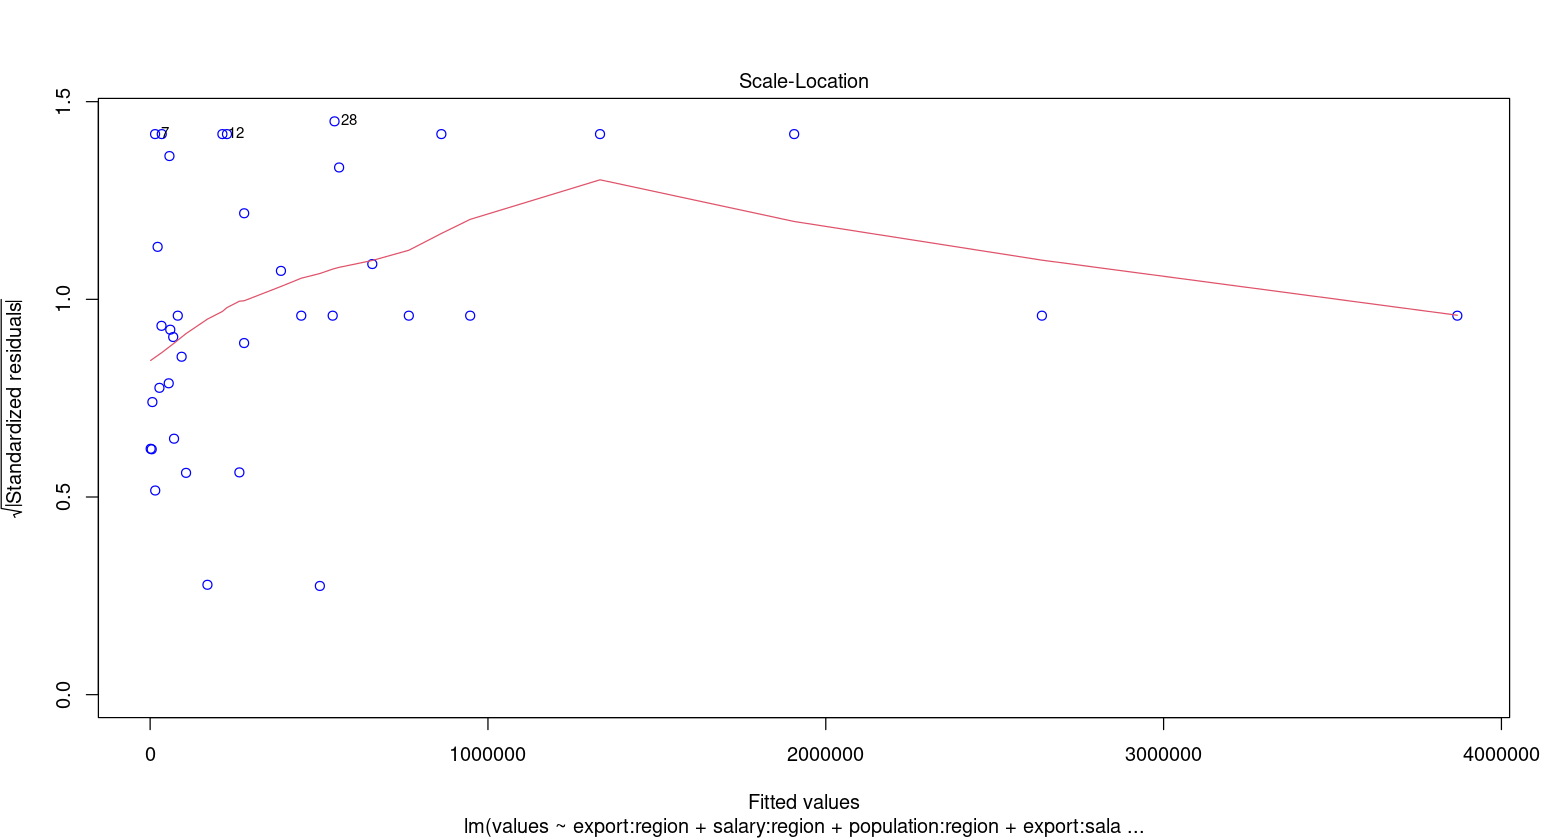


 Breusch Pagan Test for Heteroskedasticity
 -----------------------------------------
 Ho: the variance is constant            
 Ha: the variance is not constant        

                 Data                   
 ---------------------------------------
 Response : log(values) 
 Variables: fitted values of log(values) 

        Test Summary         
 ----------------------------
 DF            =    1 
 Chi2          =    0.8829194 
 Prob > Chi2   =    0.3474033 

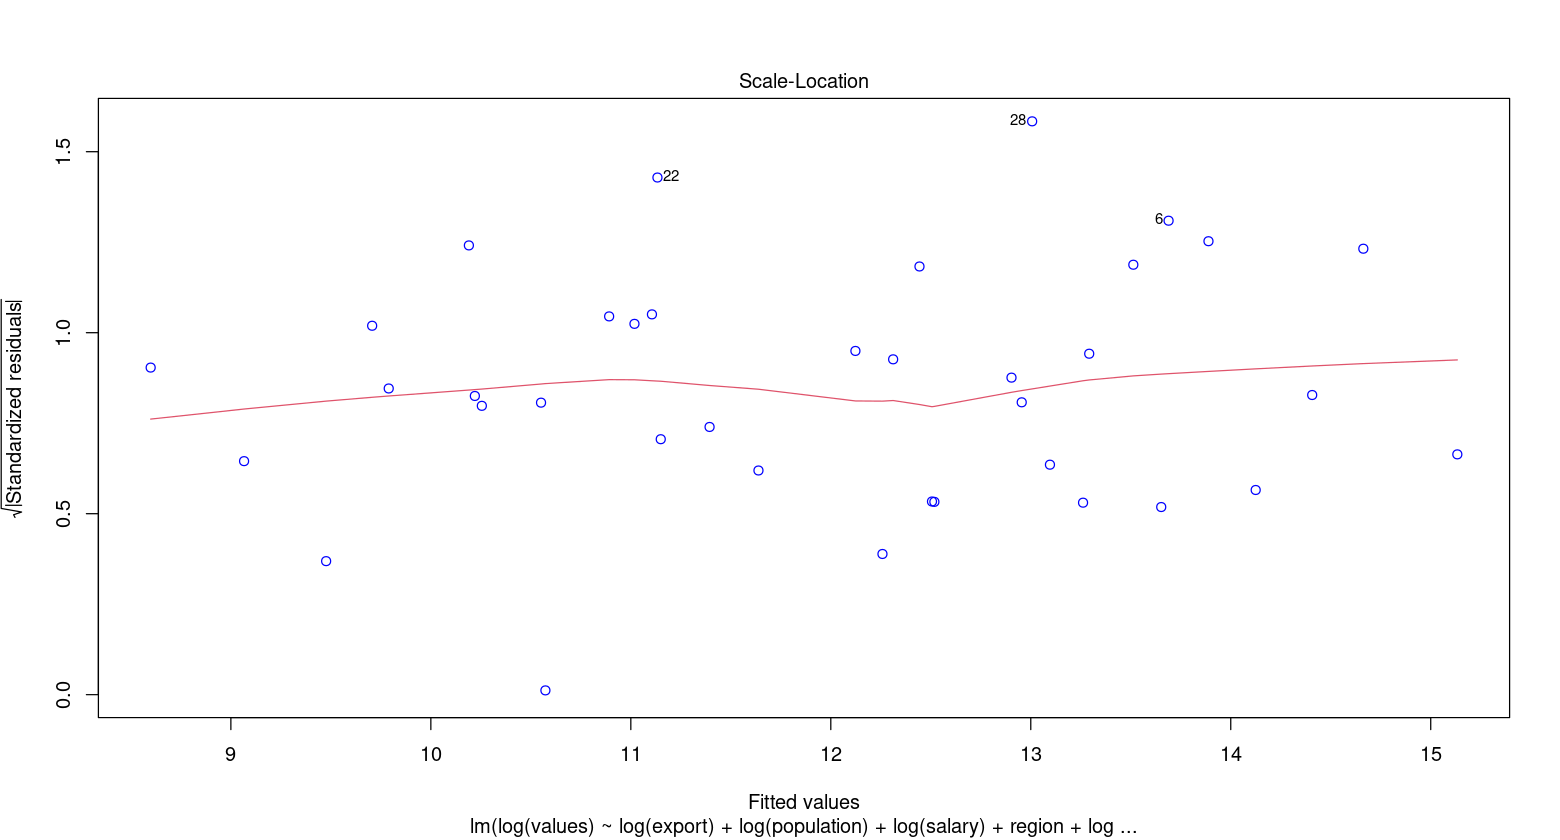

In [80]:
plot(fit.step.reduced, which=3, col=c("blue"))
ols_test_breusch_pagan(fit.step.reduced)
plot(fit.log.step, which=3, col=c("blue"))
ols_test_breusch_pagan(fit.log.step)

P-hodnota v obou případech je **větší** než 5%, proto nezamitáme nulovou hypotézu ($\mathbf{H_0:}$ **rezidua jsou homoskedastická**), což je žádoucí vlastností regresního modelu.

Vypočteme hodnotu **Akaikeho informačního kritéria** (**AIC**) pro dva různé modely: `fit.log.step` a `fit.step.reduced`. **AIC** je statistická metrika pro porovnání různých modelů. Slouží k odhadu kvality modelu a penalizuje modely s větším počtem parametrů, takže můžeme říct, že hledáme model s nejlepším kompromisem mezi přesností a složitostí. Nižší hodnota **AIC** naznačuje lepší modelovou přizpůsobivost datům.

In [83]:
AIC(fit.log.step, fit.step.reduced)

df AIC      
fit.log.step      9 -62.01726
fit.step.reduced 26 815.25789

Pro model `fit.log.step` je hodnota **AIC** rovna -62, což je negativní hodnotou a říká nám, že je relativně blíže optimálnímu modelu, než model `fit.step.reduced`, kde je tato hodnota rovna 815. Na základě těchto výsledků bychom preferovali model `fit.log.step`.

Teď se podíváme na korelaci reziduí. Pro tento účel použijeme **Breuschův-Godfreyúv** ($\mathbf{H_0:}$ **Rezidua jsou nekorelovaná**).


	Breusch-Godfrey test for serial correlation of order up to 1

data:  fit.step.reduced
LM test = 7.2894, df = 1, p-value = 0.006936


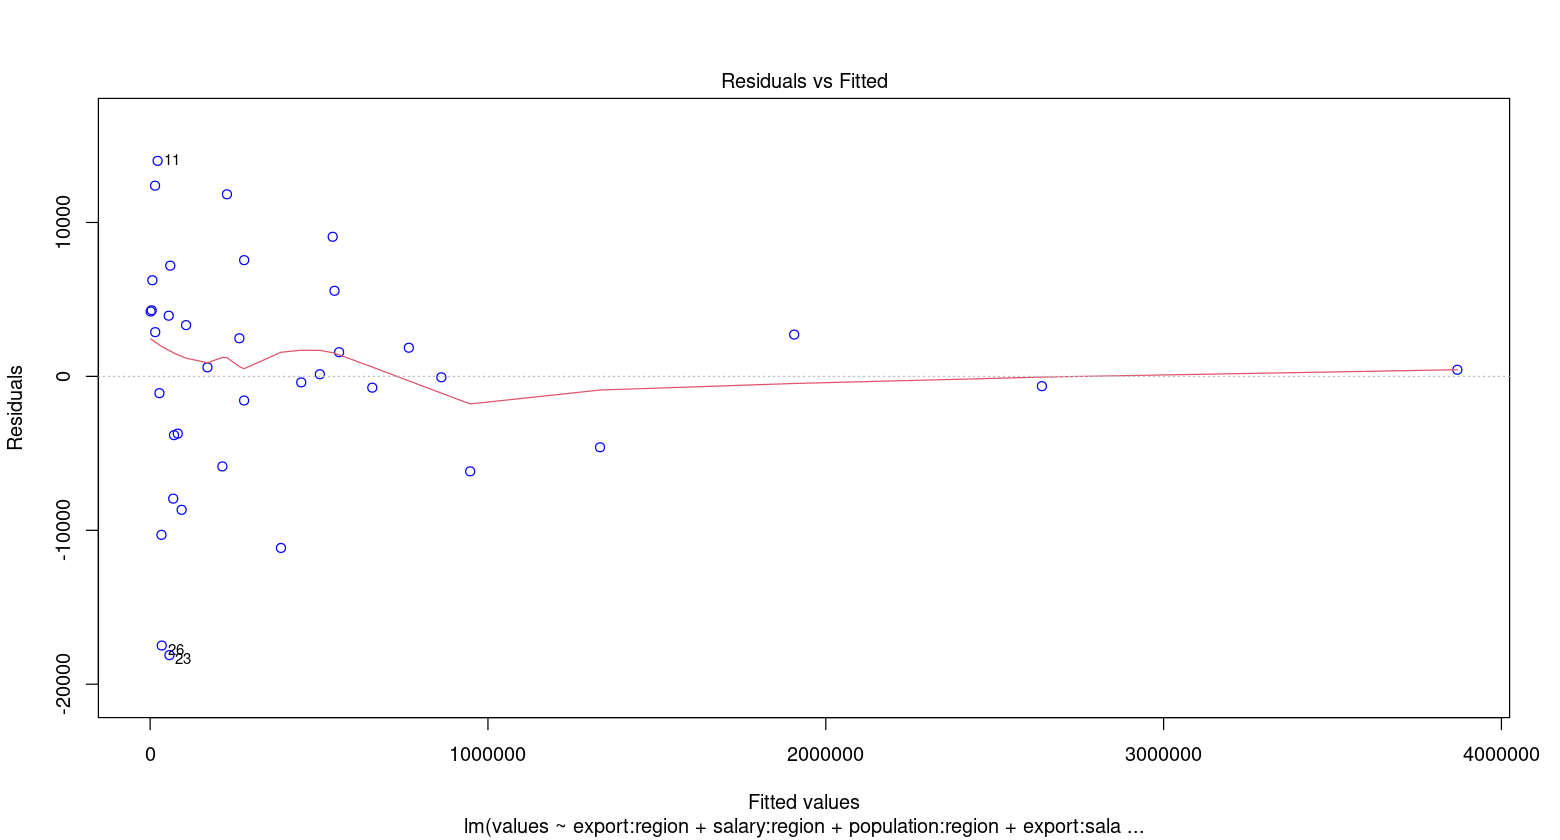

In [91]:
plot(fit.step.reduced, which=1, col=c("blue"))
bgtest(fit.step.reduced)


	Breusch-Godfrey test for serial correlation of order up to 1

data:  fit.log.step
LM test = 1.8641, df = 1, p-value = 0.1722


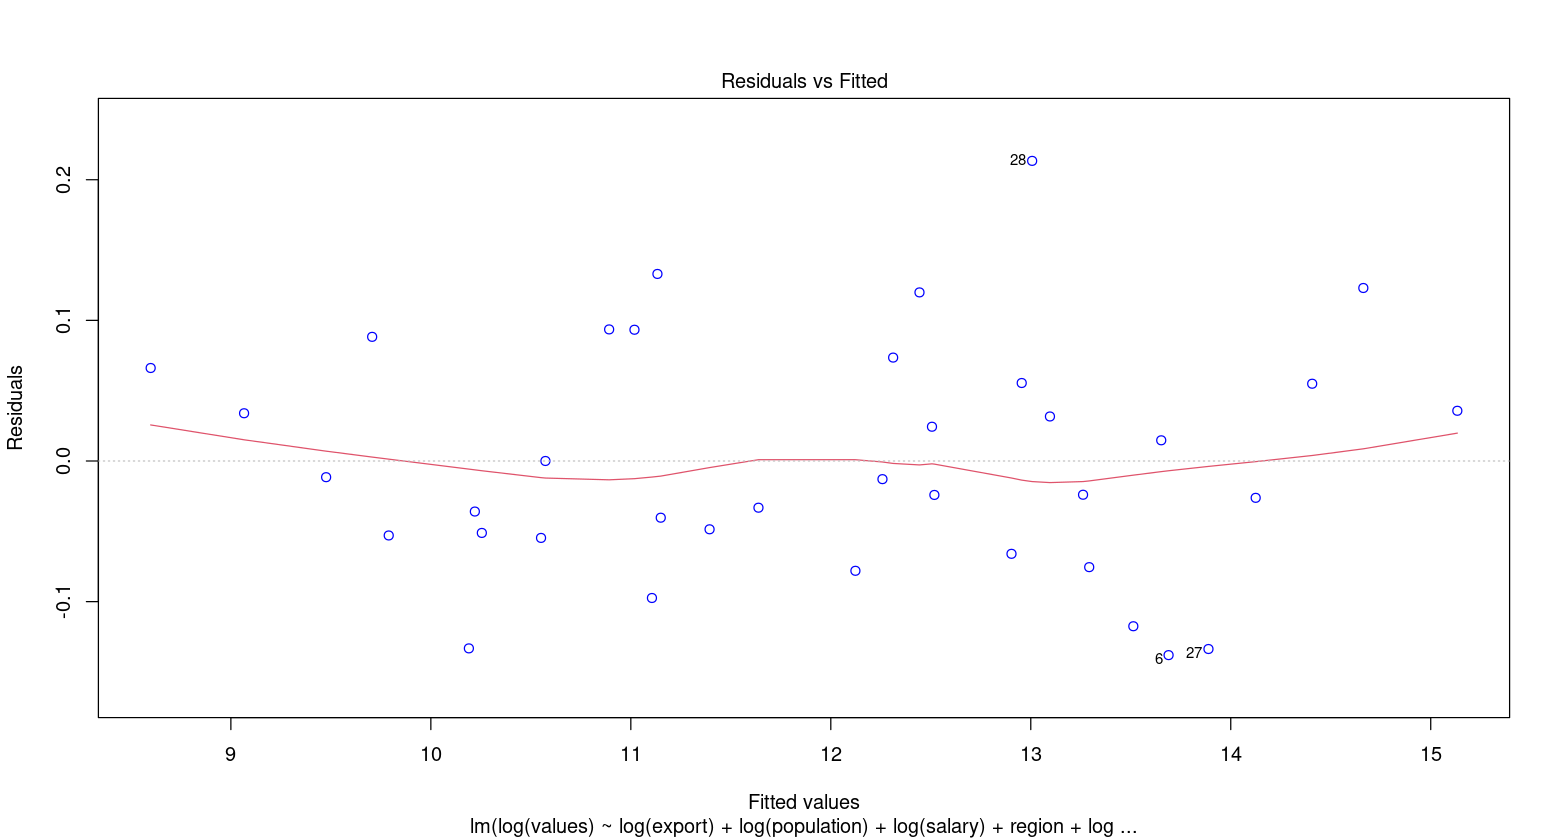

In [92]:
plot(fit.log.step, which=1, col=c("blue"))
bgtest(fit.log.step)

P-hodnota je v obou případech **větší** než 5%, proto **nezamitáme** nulovou hypotézu. Předpoklad nekorelovaností je splněn, to znamená, že model byl schopen dobře zachytit vzorce v datech a že v reziduích těchto modelů nejsou žádné významné zbývající vzorce nebo struktury. To je obecně považováno za dobrou věc.

> Identifikujte odlehlá pozorování a prozkoumejte multikolinearitu.

Multikolinearitu a závislosti mezi regresory jsme již prozkoumali v úloze č. 2. Nyní se pojďme zabývat odlehlými pozorováními. S tím nám pomůže vyšetření **Cookovy vzdálenosti**, která indikuje míru vlivu jednotlivých pozorování na hodnoty odhadů parametrů modelu. Tímto způsobem dokážeme detekovat **odlehlá pozorování (outliery)**.

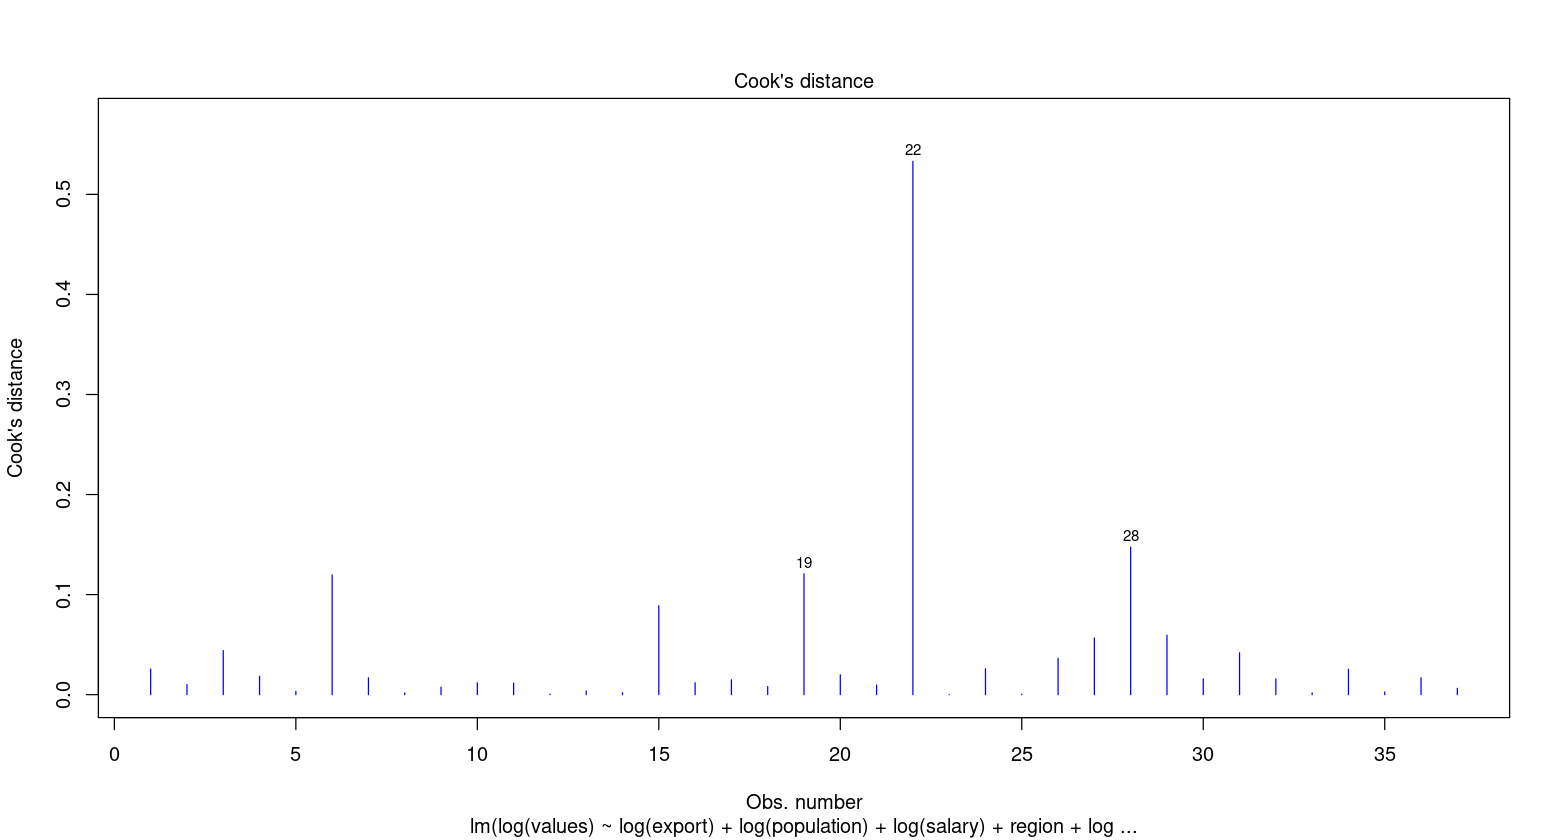

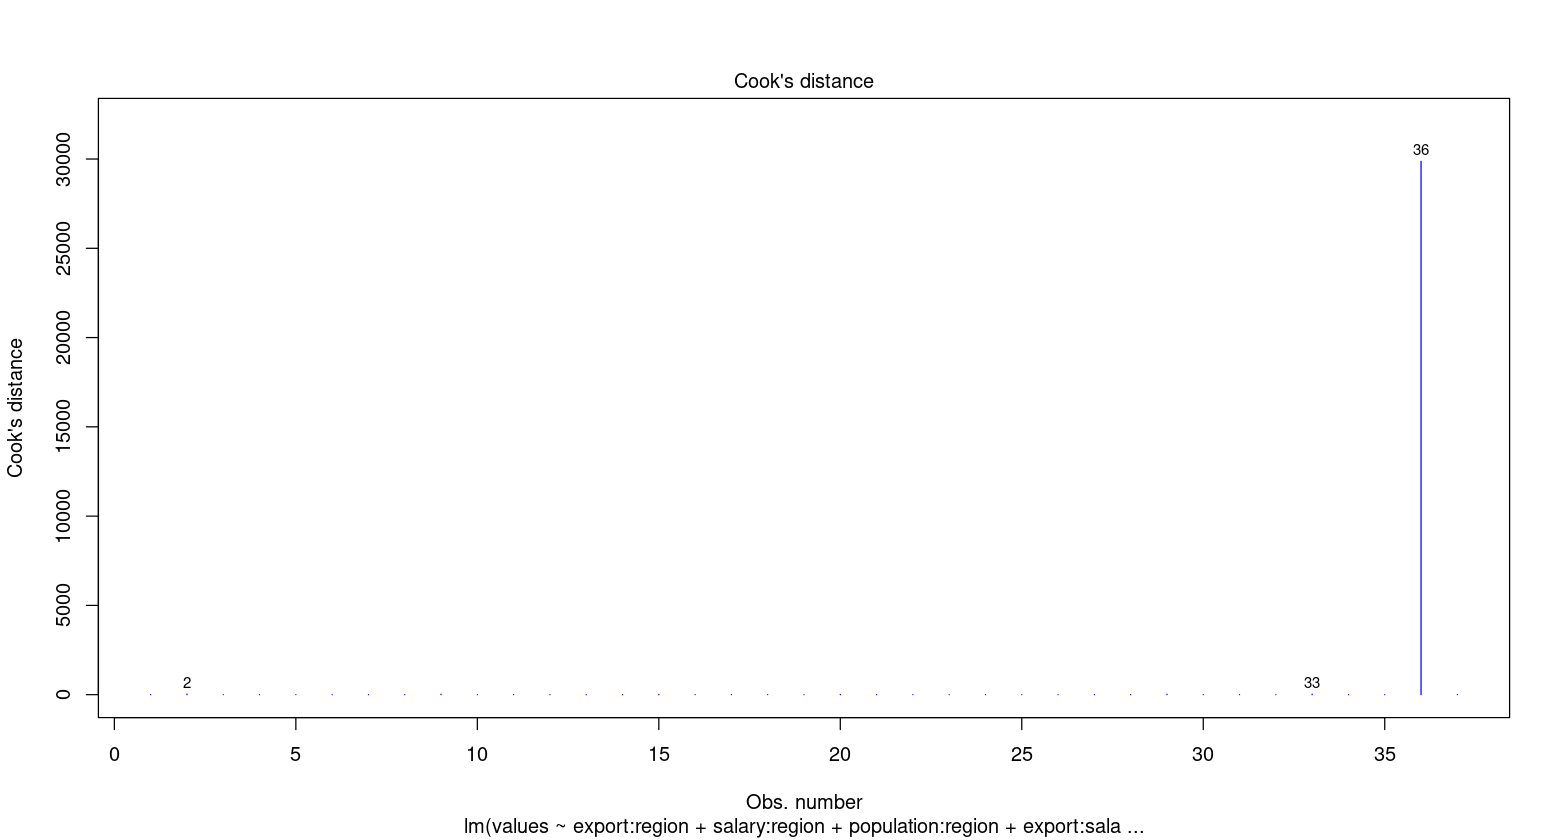

In [81]:
plot(fit.log.step, which=4, col=c("blue"))
plot(fit.step.reduced, which=4, col=c("blue"))

Warning message in sqrt(crit * p * (1 - hh)/hh):
“NaNs produced”
Warning message in sqrt(crit * p * (1 - hh)/hh):
“NaNs produced”


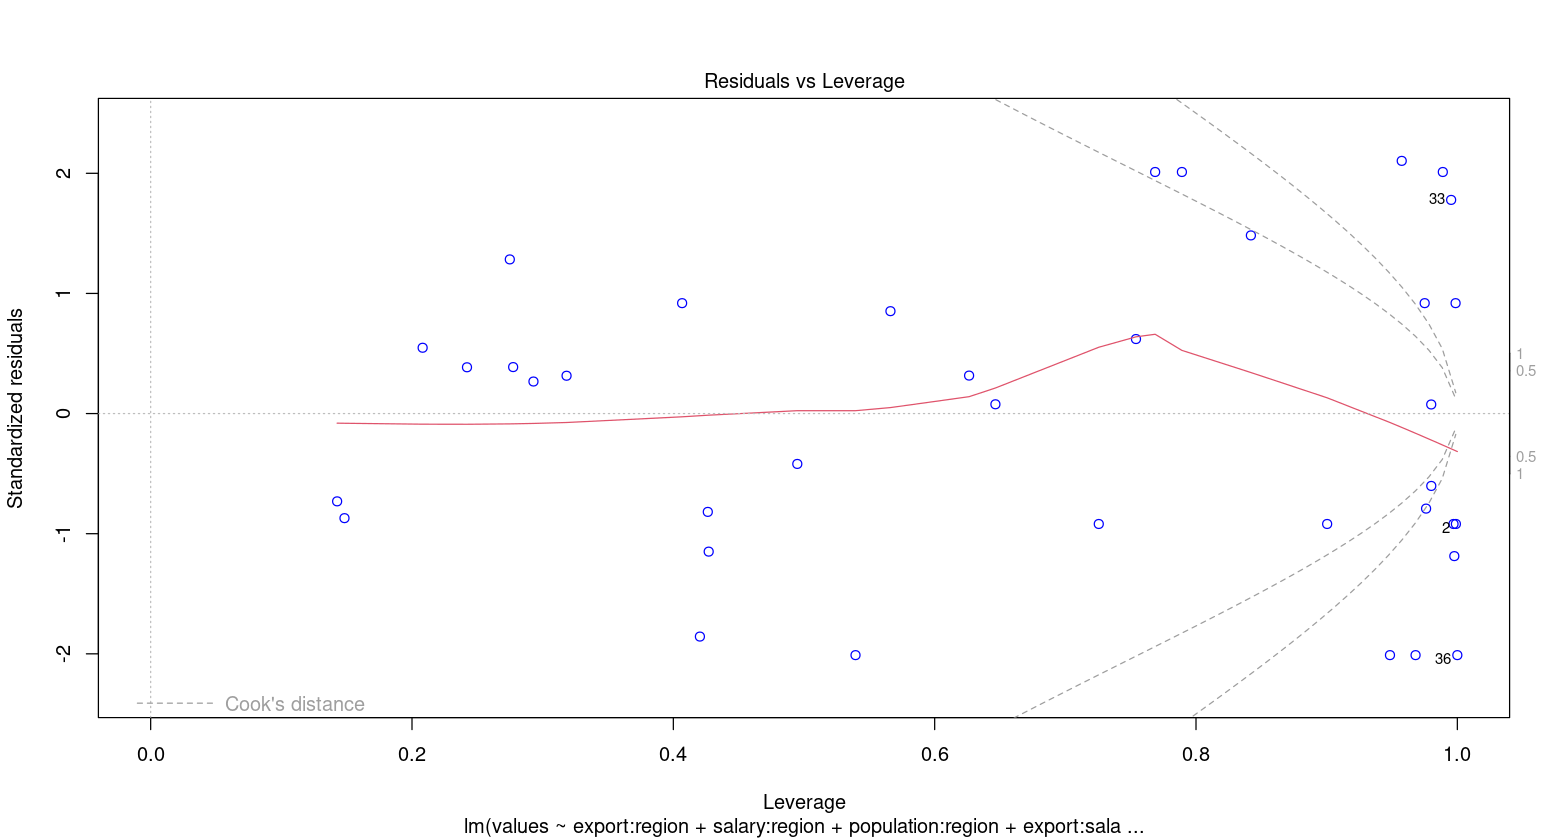

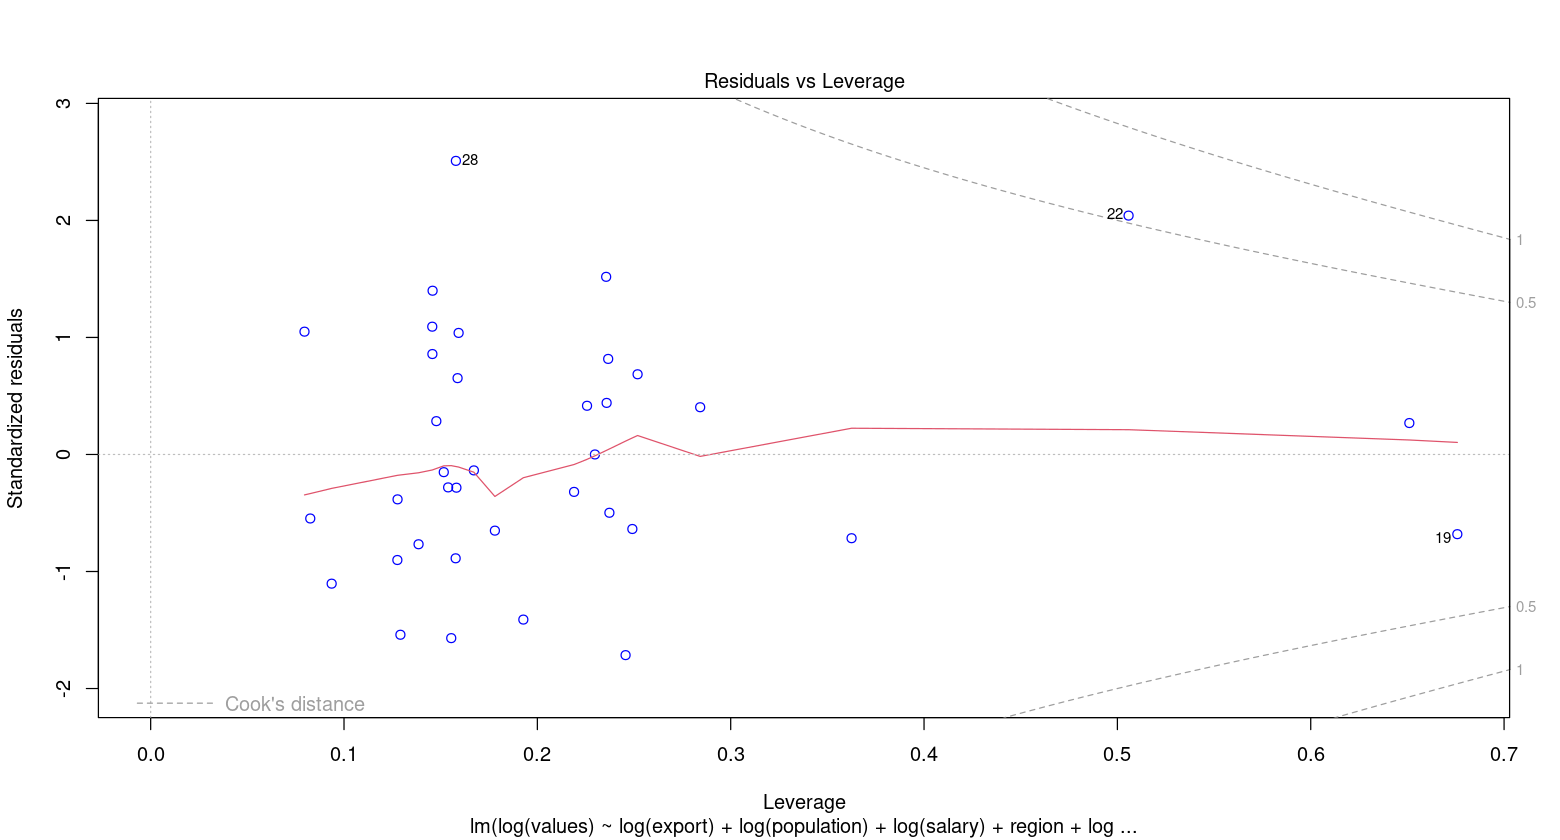

In [93]:
plot(fit.step.reduced, which=5, col=c("blue"))
plot(fit.log.step, which=5, col=c("blue"))

In [94]:
data[c(2, 19, 22, 28, 33, 36),]

geo values   population region export   salary  
2  AT  446933.3  8978929   WEST   275626.3 35837.40
19 IS   26479.3   376248   NORTH   12263.7 55324.10
22 LU   78130.1   645397   WEST   163578.2 47639.65
28 NO  551408.9  5425270   NORTH  306911.2 47902.53
33 SE  560958.6 10452326   NORTH  296508.3 35233.47
36 TR  862010.8 86735919   SOUTH  326650.5  5819.13

Pro logaritmickou regresi máme pozorování s relativně **nízkou Cookovou vzdáleností**, což je pro náš model pozitivním znakem. Tato skutečnost naznačuje, že tato odlehlá pozorování mají pouze malý vliv na odhady parametrů modelu. Mezi odlehlá pozorování patří **Island**, **Norsko** a **Lucembursko**. <br>
V případě lineární regrese už to nevypadá tak dobře. Na posledním grafu je vidět, že máme docela mnoho odlehlých pozorování v tomto modelu, což znamená, že tyto pozorování mají vlivný efekt na regresní analýzu. **Cookova vzdálenost** měří, jak moc bychom výsledky regrese změnili, kdybychom vyjmuli dané pozorování z analýzy. Pokud je **Cookova vzdálenost** vyšší než 1, znamená to, že vyjmutí daného pozorování by mělo významný vliv na výsledky regrese. Zajímavá je situace s **Tureckem**, kde Cookova vzdálenost je kolem 3000, což je hodně.

### Finální volba

Výběr **logaritmického modelu** (fit.log.step) oproti lineárnímu modelu (fit.step.reduced) **je rozumný**, protože logaritmický model **splňuje** předpoklady: **normality** reziduí, **homoskedasticity** reziduí a **nekorelovanosti** reziduí. <br> 
Navíc, logaritmický model má **nižší** hodnotu **AIC**, což naznačuje, že je lepší přizpůsoben datům. Také **adjustovaný koeficient determinace** je 0.997, což je výborný výsledek, protože je velmi blízko své maximální hodnotě (jedničce).<br>
To všechno znamená, že model byl schopen dobře zachytit vzorce v datech a nebyly nalezeny žádné významné struktury v reziduích. To je obecně považováno za pozitivní výsledek.

> Prakticky interpretujte hodnoty odhadů regresních koeficientů.

In [90]:
summary(fit.log.step)


Call:
lm(formula = log(values) ~ log(export) + log(population) + log(salary) + 
    region + log(population):log(salary), data = data_noImport)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.13804 -0.05296 -0.01290  0.05546  0.21341 

Coefficients:
                              Estimate Std. Error t value Pr(>|t|)    
(Intercept)                 -14.404720   2.568555  -5.608 4.69e-06 ***
log(export)                   0.321676   0.031978  10.059 5.77e-11 ***
log(population)               1.051020   0.167007   6.293 7.15e-07 ***
log(salary)                   1.153101   0.258651   4.458 0.000114 ***
regionNORTH                   0.135114   0.058384   2.314 0.027938 *  
regionSOUTH                  -0.007553   0.050090  -0.151 0.881186    
regionWEST                   -0.051483   0.071953  -0.716 0.480011    
log(population):log(salary)  -0.032986   0.016018  -2.059 0.048546 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.09

**Vzorec modelu**: `log(HDP) = -14.4 + 0.32*log(export) + 1.05*log(population) + 1.15*log(salary) + 0.13*if(region==NORTH) - 0.01*if(region==SOUTH) - 0.05*if(region==WEST) - 0.03*log(population)*log(salary)` + $\varepsilon_i$.

To zjednodušíme na `log(HDP)` = `-14.4 + 0.32*log(export) + 1.05*log(population) + 1.15*log(salary) + region - 0.03*log(population)*log(salary)` + $\varepsilon_i$, <br>
kde `region` = `0.13*if(region==NORTH) - 0.01*if(region==SOUTH) - 0.05*if(region==WEST)`

Po umocnění na e dostaváme: <br>
`HDP` = $e^{-14.4} \cdot e^{0.09269^2/2} \cdot export^{0.32} \cdot population^{1.05} \cdot salary^{1.15} \cdot e^{region} \cdot population^{-0.03*log(salary)}$

Pozor, pokud budou všechny regresory nulové, získáme $\operatorname E Y_i=\operatorname E( e^{\beta_0}\cdot e^{\varepsilon_i})= e^{\beta_0}\cdot \operatorname E e^{\varepsilon_i}$, přičemž v případě normality reziduí je $\operatorname E e^{\varepsilon_i}=e^{\sigma^2/2}$, kde $\sigma^2$ můžeme odhadnout pomocí reziduálního rozptylu $s^2$. Víme, že rezidua splňují předpoklad normality, z toho vyplyvá $s$ = 0.09269.

Poznámka: Když ale v našem případě alespoň jeden regresor, kromě regionu, bude nulový => $E Y_i$ = 0
 
- Při zvýšení exportu o jeden milion eur roste HDP v průměru $e^{0.32}=1.38$ krát (cca o 27.5%).

Stejně tak to platí i pro ostatní regresory.